<a href="https://colab.research.google.com/github/hamed-RM/NN-hyper-parameters-optimization-by-GA/blob/main/ferplus_large_coarse_81_6_4_60_loss_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# os.mkdir('data')
from google.colab import drive
drive.mount('/content/drive')
!unzip "drive/MyDrive/data/ckplus.zip" -d ./data/
!unzip "drive/MyDrive/data/jaffe.zip" -d ./data/
# !unzip "drive/MyDrive/data/ferplus.zip" -d ./data/
# !unzip "drive/MyDrive/data/affect net.zip" -d ./data/
!unzip "drive/MyDrive/data/ferplus retina.zip" -d ./data/
!unzip "drive/MyDrive/data/raf_db retina.zip" -d ./data/

Mounted at /content/drive
Archive:  drive/MyDrive/data/ckplus.zip
  inflating: ./data/ckplus.csv       
Archive:  drive/MyDrive/data/jaffe.zip
  inflating: ./data/jaffe.csv        
Archive:  drive/MyDrive/data/ferplus retina.zip
  inflating: ./data/ferplus.csv      
Archive:  drive/MyDrive/data/raf_db retina.zip
  inflating: ./data/raf_db.csv       


### imports

In [2]:
import cv2
from sklearn.preprocessing import normalize
# from pytorchyolo import detect,models
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import linear_sum_assignment
import os
import pandas as pd
import numpy as np
# import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.init as init
from sklearn.model_selection import train_test_split
# from torchvision.transforms import transforms
from torchvision.transforms import transforms,RandomRotation,ColorJitter,GaussianBlur,RandomHorizontalFlip,Resize,AutoAugment,AutoAugmentPolicy
import torchvision
from typing import Type as t_type
from torch import Tensor
import torch.nn.functional as F
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
# from mtcnn.mtcnn import MTCNN
# device = torch.device('cpu')
from torch.utils.data.sampler import WeightedRandomSampler
import seaborn as sns
from sklearn.metrics import confusion_matrix
import copy

np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)


### init config

In [3]:
coarse_fine_emotion_mapper={

    0:{
        0:0,
        1:1,
        2:2,
        3:4,
        4:5
    },

    1:{
        0:3
    },

    2:{
        0:6
    }

}

n_coarse_classes=len(coarse_fine_emotion_mapper)
n_fine_classes=max([len(i) for i in coarse_fine_emotion_mapper.values()])

current_epoch=-1
plot_lock=0



cnn_model_layers_1=[

    nn.Conv2d(in_channels=1,out_channels=16,kernel_size=4,stride=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.MaxPool2d(2,2),

    nn.Conv2d(in_channels=16,out_channels=6,kernel_size=2,stride=1),
    nn.BatchNorm2d(6),
    nn.ReLU()
                ]



cnn_model_layers_2=[

    nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.MaxPool2d(2,2),

    nn.Conv2d(in_channels=16,out_channels=6,kernel_size=3,stride=1),
    nn.BatchNorm2d(6),
    nn.ReLU()
                ]

coarse_mlp_layers=[

    nn.Linear(2526, 256),
    # nn.BatchNorm1d(512),
    nn.Sigmoid(),

    nn.Dropout1d(0.5),


    nn.Linear(256, 4),
    # nn.BatchNorm1d(64),
    nn.Sigmoid(),

    # nn.Dropout1d(0.3),


    nn.Linear(4,n_coarse_classes)
                    ]

fine_mlp_layers=[

                    nn.Linear(9802, 512),
                    # nn.BatchNorm1d(512),
                    nn.Sigmoid(),

                    # nn.Dropout1d(0.1),


                    nn.Linear(512, 256),
                    # nn.BatchNorm1d(64),
                    nn.Sigmoid(),

                    nn.Dropout1d(0.1),

                    nn.Linear(256, n_fine_classes)
                    ]

### defs

In [4]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        # print(f'{focal_loss=}')

        if self.reduction == 'mean':
            # print(torch.mean(focal_loss) )
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

def plot_plots(epoch,data,title):
    epoch_range=list(range(epoch+1))
    for temp_data in data:

        plt.plot(torch.tensor(epoch_range,dtype=torch.float32).cpu().numpy(),
                    torch.tensor(temp_data['data'],dtype=torch.float32).cpu().numpy(),
                    temp_data['plot_symbol'],
                    label=temp_data['title'])

    plt.title(title)
    plt.legend()
    plt.show()

def plot_matrix(y,y_pred,plot_name,is_percent=False):

    cm=confusion_matrix(y,y_pred)

    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=np.unique(y),
                yticklabels=np.unique(y))
    accuracy=sum(y==y_pred)/len(y)
    # print(f'{accuracy=}')
    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction',fontsize=13)
    plt.title(plot_name,fontsize=17)
    # plt.savefig(plot_name+'.jpg')
    plt.show()

    if is_percent:
        cm=confusion_matrix(y_pred,y,normalize='true')
        cm=np.nan_to_num(cm)
        cm = np.round(cm, decimals=2)
        cm=np.nan_to_num(cm)

        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=np.unique(y),yticklabels=np.unique(y))
        plt.ylabel('Actual',fontsize=13)
        plt.xlabel('Prediction',fontsize=13)
        plt.title('normalized '+plot_name,fontsize=17)
        plt.show()


        avg_acc=0
        for i in range(cm.shape[0]):
            avg_acc+=cm[i][i]
        print(f'avg_acc {avg_acc*100/cm.shape[0]}')


    return accuracy




def plot_tensor(tensor:Tensor):

    image_np = tensor.squeeze().cpu().numpy()

    fig, ax = plt.subplots(figsize=(224/100, 224/100), dpi=100)

    ax.imshow(image_np, cmap='gray', interpolation='none')

    ax.axis('off')  # Turn off axis labels and ticks

    plt.show()

class CustomDataset(Dataset):

    def __init__(self, imgs, combined_lbls, transform=None):
        emotion_lbls=[]
        coarse_lbls=[]
        fine_lbls=[]
        for lbl in combined_lbls:
            e,c,f=[int(t) for t in lbl.split('_')]
            # print(e,c,f)
            emotion_lbls.append(e)
            coarse_lbls.append(c)
            fine_lbls.append(f)

        print(f'{imgs.shape=},{len(emotion_lbls)=},{len(coarse_lbls)=},{len(fine_lbls)=}')
        print(f"{pd.DataFrame({'emotion':np.array(emotion_lbls)})['emotion'].value_counts()=}")

        coarse_lbls=torch.tensor(coarse_lbls, dtype=torch.float16)
        coarse_lbls=nn.functional.one_hot(coarse_lbls.to(torch.int64), num_classes=n_coarse_classes)
        coarse_lbls=coarse_lbls.to(torch.float16)

        fine_lbls=torch.tensor(fine_lbls, dtype=torch.float16)
        fine_lbls=nn.functional.one_hot(fine_lbls.to(torch.int64), num_classes=n_fine_classes)
        fine_lbls=fine_lbls.to(torch.float16)

        emotion_lbls=torch.tensor(emotion_lbls, dtype=torch.float16)

        self.imgs = imgs
        self.emotion_lbls = emotion_lbls
        self.coarse_lbls = coarse_lbls
        self.fine_lbls = fine_lbls
        self.transform = transform


    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # print(f'{idx=}')
        img,emotion_lbl, coarse_lbl, fine_lbl = self.imgs[idx], self.emotion_lbls[idx],self.coarse_lbls[idx], self.fine_lbls[idx]
        img=Image.fromarray(img)
        if self.transform != None:
            img = self.transform(img)
        # plot_tensor(img)
        return img,{'emotion':emotion_lbl,'coarse':coarse_lbl,'fine':fine_lbl}

def string_to_array(x):
    result=np.array(x.split(' '),dtype=np.uint8).reshape(48,48)
    return result



### prepare data
<table>
<tr>
<th> expression:emotion_lbl </th>
<th>emotion_lbl: 'coarse_fine' </th>
</tr>
<tr>
<td>

'anger':0<br>
'disgust':1<br>
'fear':2<br>
'happy':3<br>
'sad':4<br>
'surprise':5<br>
'neutral':6<br>

</td>
<td>

3:'0_0'<br>

0:'1_0'<br>
1:'1_1'<br>
2:'1_2'<br>
4:'1_3'<br>

5:'2_0'<br>

6:'3_0'<br>

</td>

</tr>
</table>

In [5]:
def get_dataloader(ds,batch_size,data_percent,usage):
    if usage=='coarse':
        balanced_lbl_dist=np.array([0.2,
                                    0.2,
                                    0.2,
                                    1.0,
                                    0.2,
                                    0.2,
                                    1.0])
    else:
        balanced_lbl_dist=np.array([0.25,1.0,1.0,0.25,1.0,0.25,0.25])


    unique_values, unique_counts=torch.unique(ds.emotion_lbls,return_counts=True)
    class_weights = 1.0 /unique_counts
    # print(f'{usage=},{unique_counts=},{class_weights=},{class_weights*unique_counts}')

    class_weights=class_weights*balanced_lbl_dist


    weights = torch.tensor([class_weights[int(label)] for label in ds.emotion_lbls])
    sampler = WeightedRandomSampler(weights, num_samples=int(len(weights)*data_percent), replacement=True)
    dataloader = DataLoader(ds, batch_size=batch_size, sampler=sampler, pin_memory=True)
    # dataloader = DataLoader(ds, batch_size=batch_size,shuffle=True)

    return dataloader

def get_dataloaders(dfs_names,batch_size,data_percent=1.0,img_size=(100,100)):

    dfs=[]

    for d in dfs_names:
        dfs.append(pd.read_csv(f'./data/{d}.csv'))
    df=pd.concat(dfs,axis=0,ignore_index=True)
    condition=(df['emotion']==7)
    df=df[~condition]


    for temp_coarse in coarse_fine_emotion_mapper:
        for temp_fine in coarse_fine_emotion_mapper[temp_coarse]:
            temp_emotion=coarse_fine_emotion_mapper[temp_coarse][temp_fine]

            df.loc[df['emotion'] == temp_emotion, ['coarse', 'fine']] = [temp_coarse,temp_fine]

    X = np.array(df['pixels'].apply(lambda x: string_to_array(x)).tolist())
    # print(f'{X.shape=}')
    # print(df.head(10))
    coarse_class_weights = [factor for factor in compute_class_weight('balanced',
                                                                      classes=np.unique(df['coarse'].values),
                                                                      y=df['coarse'].values)]
    coarse_class_weights = torch.FloatTensor(coarse_class_weights)

    fine_class_weights = [factor for factor in compute_class_weight('balanced',
                                                                      classes=np.unique(df['fine'].values),
                                                                      y=df['fine'].values)]
    fine_class_weights = torch.FloatTensor(fine_class_weights)

    class_weights_dict={'coarse':coarse_class_weights,'fine':fine_class_weights}

    y_coarse=np.array(df['coarse']).astype(np.uint8)

    y_fine=np.array(df['fine']).astype(np.uint8)

    y_emotion=df['emotion'].astype(np.uint8)


    combined_lbls=[f'{e}_{c}_{f}' for e,c,f in zip (y_emotion,y_coarse,y_fine)]

    x_train, x_valid_test, y_train_combined, y_valid_test_combined = train_test_split(X, combined_lbls, train_size=0.8, random_state=7,
                                                        shuffle=True,stratify=combined_lbls)
    x_valid, x_test, y_valid_combined, y_test_combined = train_test_split(x_valid_test, y_valid_test_combined, train_size=0.5, random_state=7,
                                                        shuffle=True,stratify=y_valid_test_combined)



    # img_size=(100,100)
    train_transform = transforms.Compose([
                # transforms.RandomResizedCrop(224),
                # AutoAugment(AutoAugmentPolicy.IMAGENET),
                transforms.RandomHorizontalFlip(p=0.5),
                Resize(img_size),
                # transforms.RandomApply([transforms.ColorJitter(brightness=0.1)], p=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])

                ])
    valid_transform = transforms.Compose([
                Resize(img_size),
                transforms.ToTensor(),  # Convert to PyTorch tensor
                transforms.Normalize(mean=[0.5], std=[0.5])
                ])



    dataset_train = CustomDataset(x_train,y_train_combined,transform=train_transform)
    dataset_valid = CustomDataset(x_valid, y_valid_combined,transform=valid_transform)
    dataset_test = CustomDataset(x_test, y_test_combined,transform=valid_transform)
    data_loaders_dict={}
    for usage in ['coarse','fine']:
        data_loaders_dict[usage]={}
        data_loaders_dict[usage]['train']=get_dataloader(dataset_train,batch_size=batch_size,data_percent=data_percent,usage=usage)
        data_loaders_dict[usage]['valid']=get_dataloader(dataset_valid,batch_size=batch_size,data_percent=data_percent,usage=usage)
        data_loaders_dict[usage]['test'] = DataLoader(dataset_test, batch_size=batch_size,shuffle=True)

        # data_loaders_dict[usage]['test']=get_dataloader(dataset_test,batch_size=batch_size,data_percent=data_percent,usage=usage)

    # dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    # dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)


    return data_loaders_dict,class_weights_dict

### cnn_branch

In [6]:
class CNN_BRANCH(nn.Module):

    def __init__(self,layers):

        super(CNN_BRANCH,self).__init__()


        self.model=nn.ModuleList(layers)

    def forward(self, x):
        global current_epoch,plot_lock

        # shortcut_data=None
        for idx_layer , layer in enumerate(self.model):

            x=layer(x)

            # if (current_epoch+1)%10==0:
            #     self.plot_kernels(x[0],layer=layer,layer_idx=idx_layer)
            #     if idx_layer+1==len(self.model):
            #         plot_lock+=1


        return x

    def plot_kernels(self,kernels,layer,layer_idx):
        global plot_lock
        if plot_lock>1:
          return


        print(f'layer={layer},n_feature={kernels.shape[0]}({kernels.shape[1:]}),{layer_idx=}')

        max_col_fig=kernels.shape[0] if kernels.shape[0]<8 else 8
        max_row_fig=(kernels.shape[0]-1//max_col_fig)+1
        # fig, axes = plt.subplots(max_row_fig, max_col_fig,figsize=(16,16))
        fig, axes = None,None




        for idx_img,img in enumerate(kernels):
            if (idx_img)%max_col_fig==0:
                fig, axes = plt.subplots(1, max_col_fig,figsize=(8,8))
                if ((idx_img+max_col_fig)>kernels.shape[0]):

                    for j in range((idx_img+1)%max_col_fig, max_col_fig):
                        fig.delaxes(axes.flat[j])

            axes[idx_img%max_col_fig].imshow(img.detach().cpu().numpy(), cmap='gray')
            axes[idx_img%max_col_fig].set_xticks([]), axes[idx_img%max_col_fig].set_yticks([])

            if (idx_img+1)%max_col_fig==0:
                plt.show()
            if idx_img==(kernels.shape[0]-1):
                plt.show()


### Coarse feature extractor model

In [7]:
class Coarse_Feature_Extractor(nn.Module):

    def __init__(self,layers_list):
        super(Coarse_Feature_Extractor,self).__init__()
        self.cnn_branch_list=nn.ModuleList()
        for layer in layers_list:
            self.cnn_branch_list.append(CNN_BRANCH(layers=layer))



    def forward(self, x):

        result=[]
        for model in self.cnn_branch_list:
            result.append(model(x))



        return result


### Coarse classifier

In [8]:
class Coarse_classifier(nn.Module):

    def __init__(self,criterion,coarse_feature_extractor_layers_list,coarse_mlp_layers):
        super(Coarse_classifier,self).__init__()

        self.criterion=criterion
        self.optimizer = None
        self.scheduler_dict = None
        self.patience=5

        self.feature_extractor=Coarse_Feature_Extractor(layers_list=coarse_feature_extractor_layers_list)
        self.coarse_mlp_model=nn.Sequential(*coarse_mlp_layers)
        # self.flt = nn.Flatten()
        self.feature_extractor.apply(self.init_weights)
        self.coarse_mlp_model.apply(self.init_weights)



        self.loss_acc_info={
                'train':{'acc':[],'loss':[]},
                'valid':{'acc':[],'loss':[]},
                'test':{'acc':[],'loss':[]}
        }

        # self.checkpoint = {
        # 'epoch':-1,
        # 'model_state_dict': self.state_dict(),
        # 'loss_acc_info':self.loss_acc_info
        # }
        self.best_checkpoint={
            'model_state_dict':self.state_dict(),
            'acc':0,
            'loss':100
            }


    def forward(self, x):

        features=[]
        features_list=self.feature_extractor(x)
        batch_size=features_list[0].shape[0]
        for f in features_list:
            # print(f'{f=}')
            # print(f'{f.shape=}')

            # print(f'{self.flt(f)=}')
            # print(f'{self.flt(f).shape=}')
            flattened=f.view(batch_size, -1)
            # print(f'{flattened.shape=}')

            # if flattened.grad_fn == None:
            #     print('error')
            features.append(flattened)
        features=torch.cat(features,dim=1)
        # print(f'{features=}')
        # print(f'{features.shape=}')



        coarse_output=self.coarse_mlp_model(features)


        # print(f'{features=}')
        # print(f'{features.shape=}')

        # print(f'{coarse_output=}')
        # print(f'{coarse_output.shape=}')



        return coarse_output



    def init_weights(self,m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)

        if isinstance(m, nn.Conv2d):
            init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                init.zeros_(m.bias)

    def cal_loss(self,y_pred,y_target):

        return self.criterion(y_pred, y_target)


    def eval_model(self,dl_dict):
        global current_epoch
        self.eval()
        # print('evaluation')
        with torch.no_grad():

            for dl_type_temp , dl_temp in dl_dict.items():
                # print(f'{dl_type_temp=}')
                total = 0
                correct=0
                running_loss=0

                all_pred=[]
                all_target=[]

                for x,y_dict in dl_temp:

                    x=x.to(device)

                    y=y_dict['coarse'].to(device)

                    output= self(x)

                    loss=self.cal_loss(y_pred=output, y_target=y)

                    running_loss += loss.item()

                    predicted=output.argmax(dim=1).detach().cpu().numpy()
                    target=y.argmax(dim=1).detach().cpu().numpy()

                    all_target.extend(list(target))
                    all_pred.extend(list(predicted))

                    total += y.size(0)

                    correct += (predicted==target).sum()

                if (current_epoch+1)%3==0:

                    plot_matrix(y=np.array(all_target),y_pred=np.array(all_pred),plot_name=dl_type_temp+' coarse confusion matrix',is_percent=True)



                avg_loss=running_loss/len(dl_temp)

                acc=(100*correct/total)


                self.loss_acc_info[dl_type_temp]['loss'].append(avg_loss)

                self.loss_acc_info[dl_type_temp]['acc'].append(acc)

                if dl_type_temp == 'valid' :
                    self.scheduler.step(avg_loss)

                if dl_type_temp == 'test' and acc>=self.best_checkpoint['acc']:
                    self.best_checkpoint['acc']=acc

                if dl_type_temp == 'test' and avg_loss<=self.best_checkpoint['loss']:

                    # self.best_checkpoint['model_state_dict']=copy.deepcopy(self.state_dict())
                    self.best_checkpoint['loss']=avg_loss


    def one_step_train(self,dl):
        self.train()
        print('train started')

        for x,y_dict in dl:
            self.optimizer.zero_grad()

            x=x.to(device)

            y=y_dict['coarse'].to(device)

            output = self(x)
            loss=self.cal_loss(y_pred=output, y_target=y)

            loss.backward()
            self.optimizer.step()
        print('train finished')



    def train_model(self,num_epochs,dataloader_dict):

        global current_epoch,plot_lock

        for epoch in range(num_epochs):
            print('epoch:',epoch)

            plot_lock=0
            current_epoch=epoch
            # if min(self.loss_acc_info['valid']['loss'][-self.patience:])<

            self.one_step_train(dataloader_dict['train'])
            self.eval_model(dataloader_dict)



            if (current_epoch+1)%5==0:

                plot_plots(
                    epoch=epoch,
                    data=[
                    {'title':'Train Coarse Accuracy','data':self.loss_acc_info['train']['acc'],'plot_symbol':'ro'},
                    {'title':'Validation Coarse Accuracy','data':self.loss_acc_info['valid']['acc'],'plot_symbol':'rv'},
                    {'title':'Test Coarse Accuracy','data':self.loss_acc_info['test']['acc'],'plot_symbol':'r'}
                            ],
                    title=f'Accuracy\nbest test acc:{self.best_checkpoint["acc"]:.4e}'
                )

                plot_plots(
                    epoch=epoch,
                    data=[
                    {'title':'Train Coarse Loss','data':self.loss_acc_info['train']['loss'],'plot_symbol':'ro'},
                    {'title':'Validation Coarse Loss','data':self.loss_acc_info['valid']['loss'],'plot_symbol':'rv'},
                    {'title':'Test Coarse Loss','data':self.loss_acc_info['test']['loss'],'plot_symbol':'r'}
                            ],
                    title=f'Loss\nlr:{self.optimizer.param_groups[0]["lr"]:.2e},best test loss:{self.best_checkpoint["loss"]:.3e}'

                )

# \nloss_train={self.loss_acc_info[usage]["train"]["total_loss"][-1]:.3e},loss_valid={self.loss_acc_info[usage]["valid"]["total_loss"][-1]:.3e},loss_test={self.loss_acc_info[usage]["test"]["total_loss"][-1]:.3e}'

        #     self.checkpoint = {
        # 'epoch':epoch,
        # 'model_state_dict': copy.deepcopy(self.state_dict()),
        # 'optimizer_state_dict': copy.deepcopy(self.optimizer.state_dict()),
        # 'scheduler_state_dict': copy.deepcopy(self.scheduler.state_dict()),
        # 'loss_acc_info':copy.deepcopy(self.loss_acc_info)
        # }

        # # Save the checkpoint
        # torch.save(self.checkpoint, 'checkpoint.pth')


### load data




In [18]:
dfs_names=['ferplus']
batch_size = 512
dataloader_dict,class_weights_dict= get_dataloaders(dfs_names,batch_size=batch_size,data_percent=1.0,img_size=(100,100))
print(f'{class_weights_dict["coarse"]=}\n{class_weights_dict["fine"]=}')

imgs.shape=(24948, 48, 48),len(emotion_lbls)=24948,len(coarse_lbls)=24948,len(fine_lbls)=24948
pd.DataFrame({'emotion':np.array(emotion_lbls)})['emotion'].value_counts()=emotion
6    8978
3    7220
5    3142
4    2921
0    2065
2     508
1     114
Name: count, dtype: int64
imgs.shape=(3118, 48, 48),len(emotion_lbls)=3118,len(coarse_lbls)=3118,len(fine_lbls)=3118
pd.DataFrame({'emotion':np.array(emotion_lbls)})['emotion'].value_counts()=emotion
6    1122
3     902
5     393
4     365
0     258
2      63
1      15
Name: count, dtype: int64
imgs.shape=(3119, 48, 48),len(emotion_lbls)=3119,len(coarse_lbls)=3119,len(fine_lbls)=3119
pd.DataFrame({'emotion':np.array(emotion_lbls)})['emotion'].value_counts()=emotion
6    1122
3     903
5     393
4     365
0     258
2      64
1      14
Name: count, dtype: int64
class_weights_dict["coarse"]=tensor([0.9504, 1.1518, 0.9263])
class_weights_dict["fine"]=tensor([ 0.2732, 43.6154,  9.8220,  1.7083,  1.5878])


### training coarse model

In [19]:

torch.cuda.empty_cache()
device = torch.device('cuda')
# criterion_coarse = nn.CrossEntropyLoss(weight=class_weights_dict['coarse'])
# criterion_fine = nn.CrossEntropyLoss(weight=class_weights_dict['fine'])

criterion_coarse = nn.CrossEntropyLoss()
# criterion_fine = nn.CrossEntropyLoss()

# criterion_coarse = FocalLoss(alpha=0.25,gamma=2,reduction='mean')
# criterion_fine = FocalLoss(alpha=0.25,gamma=2,reduction='mean')
lr=0.001
epochs=100

coarse_classifier_model=Coarse_classifier(criterion=criterion_coarse,
                                 coarse_feature_extractor_layers_list=[cnn_model_layers_1,cnn_model_layers_2],
                                 coarse_mlp_layers=coarse_mlp_layers
                                 ).to(device)



optimizer_coarse = optim.Adam(coarse_classifier_model.parameters(),lr=lr,weight_decay=1e-4)

scheduler_coarse = ReduceLROnPlateau(optimizer_coarse, mode='min', patience=1, factor=0.95)



coarse_classifier_model.optimizer=optimizer_coarse

coarse_classifier_model.scheduler=scheduler_coarse


# combined_model.checkpoint['optimizer_state_dict']=combined_model.optimizer.state_dict()
# combined_model.checkpoint['scheduler_state_dict']=combined_model.scheduler.state_dict()
# combined_model.load_state_dict(torch.load('model.pth'))
# if os.path.isfile('checkpoint.pth'):
#     combined_model.checkpoint=torch.load('checkpoint.pth')

In [ ]:
for name, param in coarse_classifier_model.named_parameters() :
    print(name)

In [ ]:
# from google.colab import files
# coarse_model = torch.load('coarse model.pth')
# torch.save(combined_model,'combined model 0.25 0.25 0 .pth')
num_parameters = sum(p.numel() for p in coarse_classifier_model.parameters())

print(f"Total number of parameters in fine model: {num_parameters}")

# files.download('/content/coarse model.pth')

Total number of parameters in fine model: 434011


epoch: 0
train started
train finished
epoch: 1
train started
train finished
epoch: 2
train started
train finished


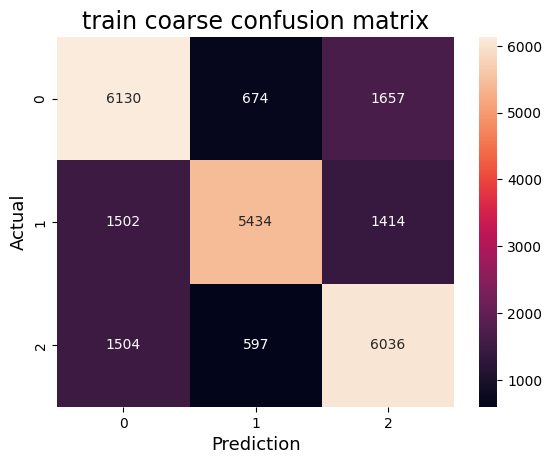

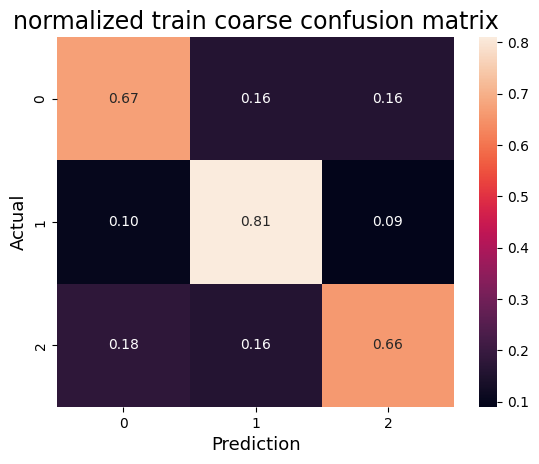

avg_acc 71.33333333333333


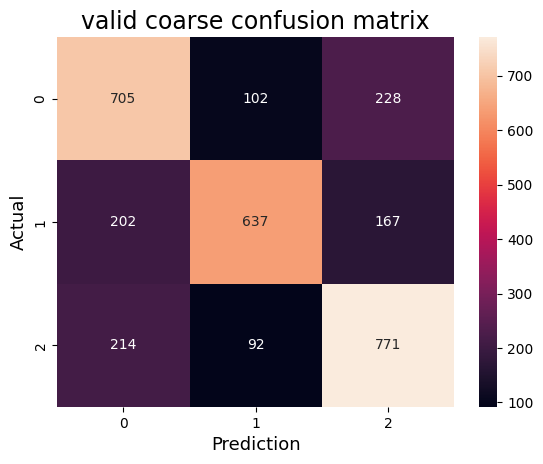

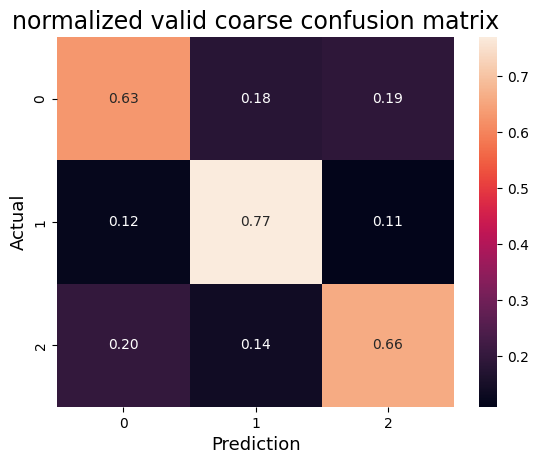

avg_acc 68.66666666666667


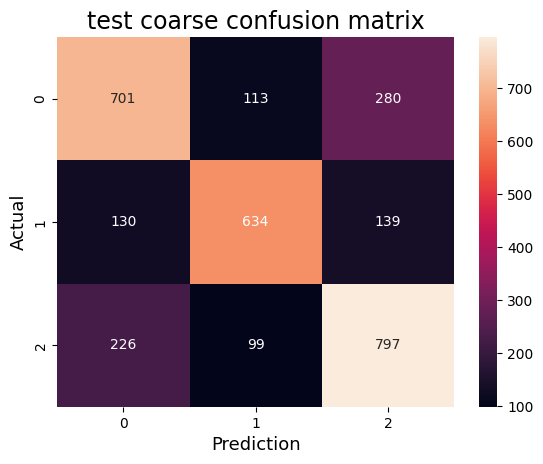

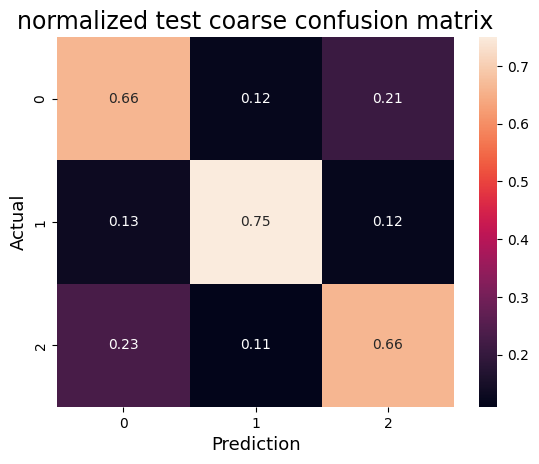

avg_acc 69.00000000000001
epoch: 3
train started
train finished
epoch: 4
train started
train finished


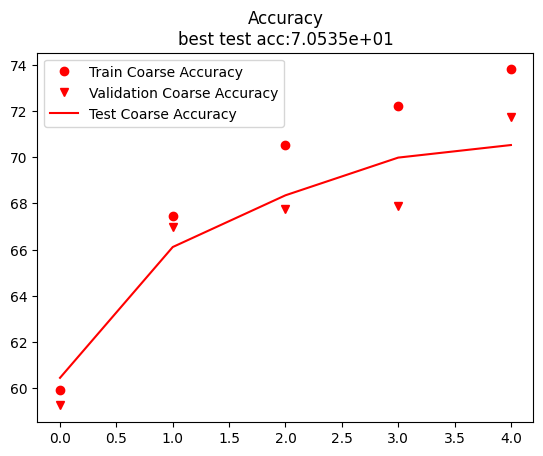

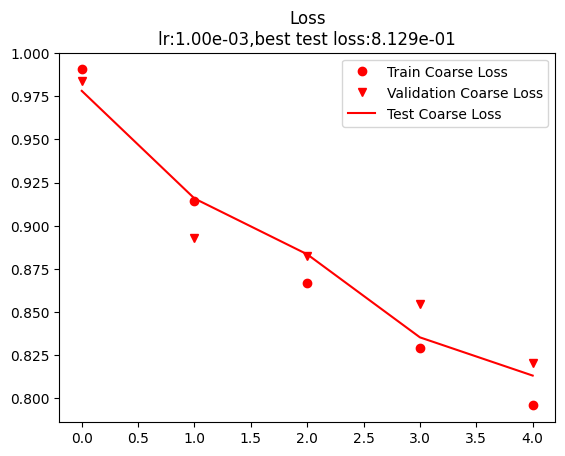

epoch: 5
train started
train finished


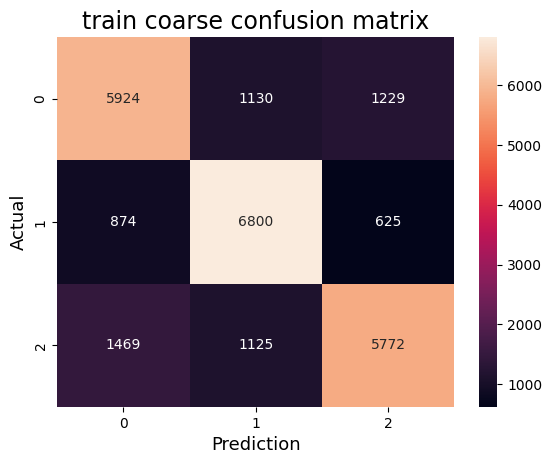

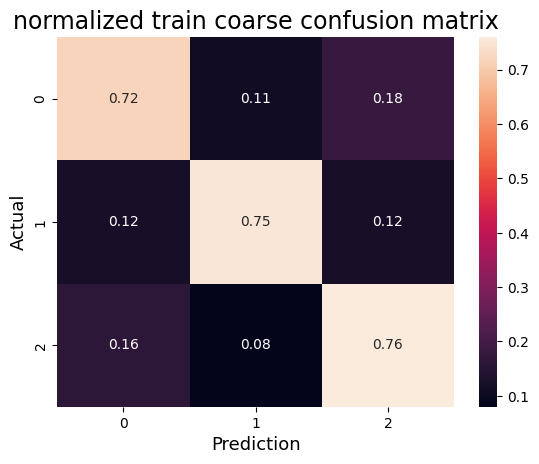

avg_acc 74.33333333333333


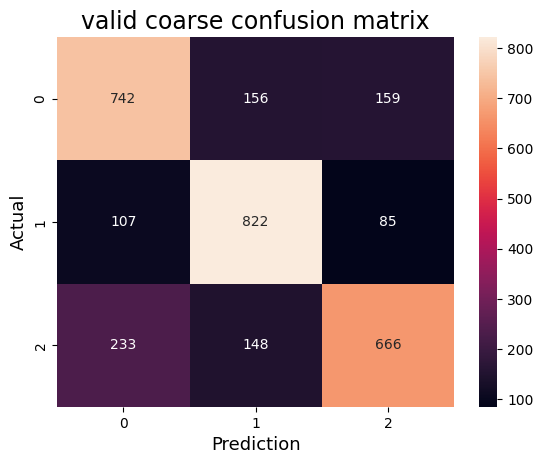

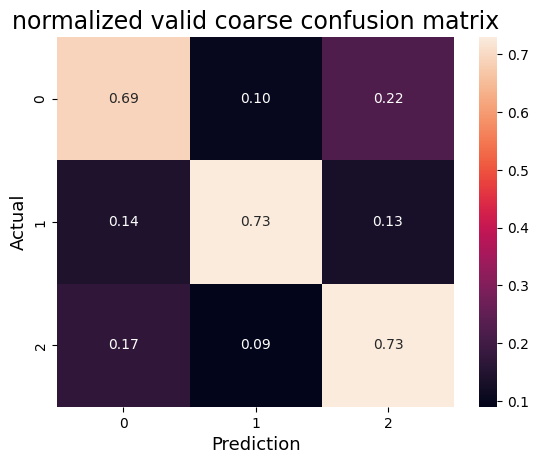

avg_acc 71.66666666666667


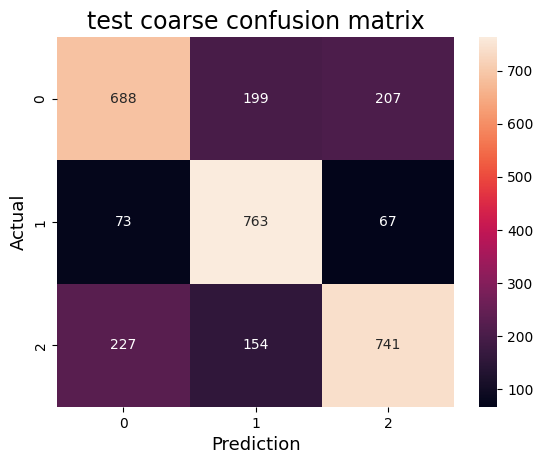

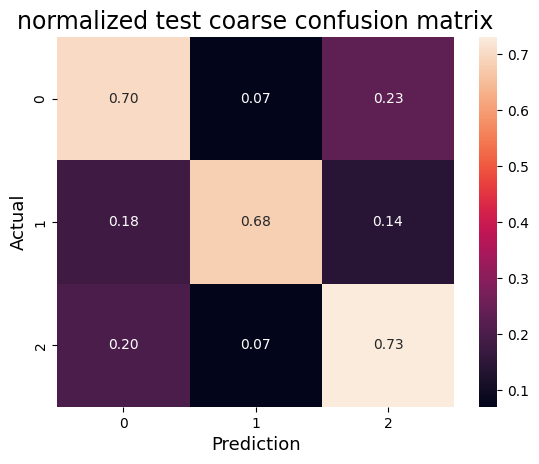

avg_acc 70.33333333333333
epoch: 6
train started
train finished
epoch: 7
train started
train finished
epoch: 8
train started
train finished


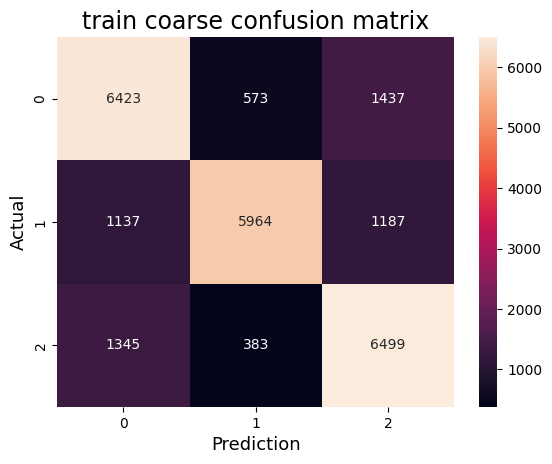

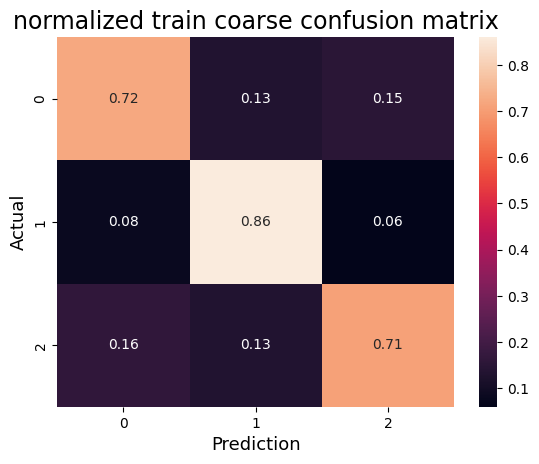

avg_acc 76.33333333333333


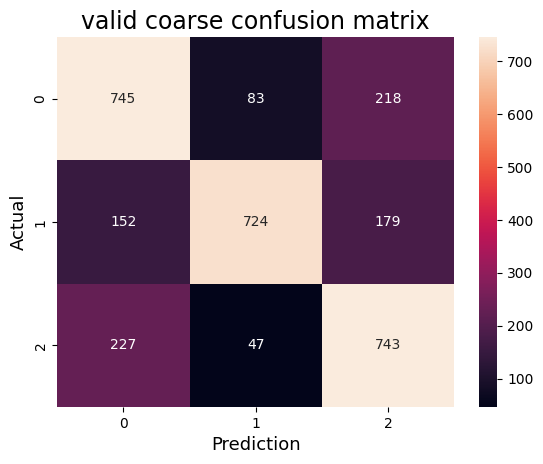

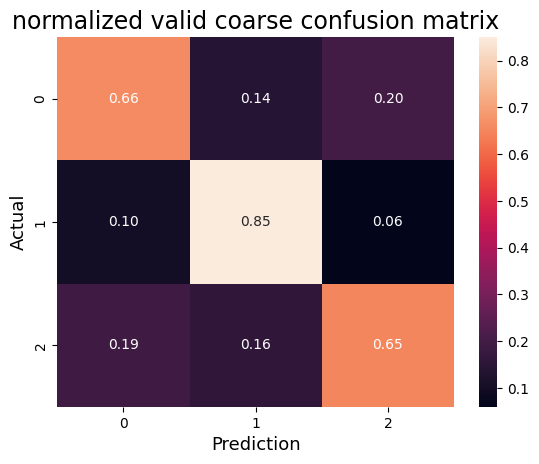

avg_acc 72.0


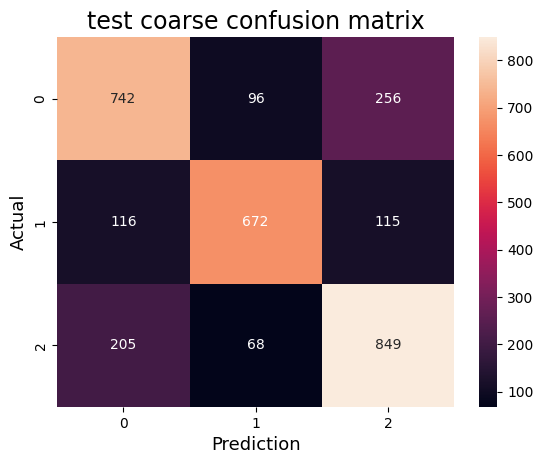

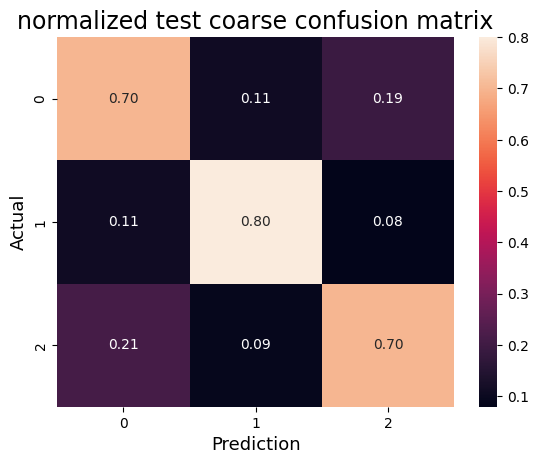

avg_acc 73.33333333333334
epoch: 9
train started
train finished


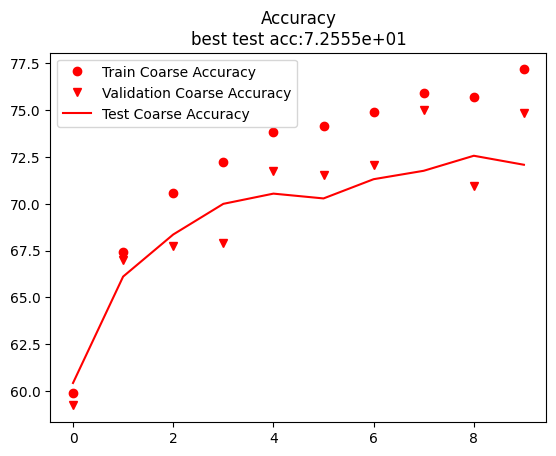

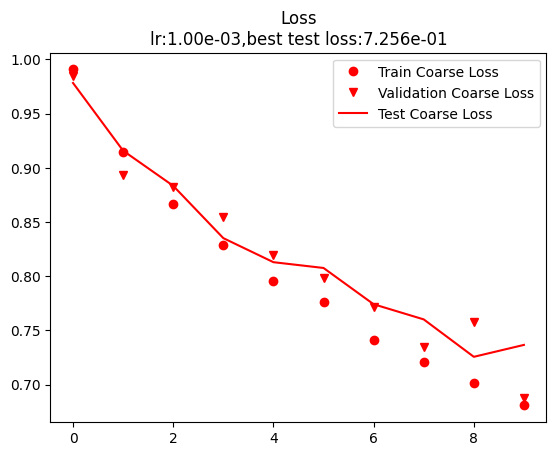

epoch: 10
train started
train finished
epoch: 11
train started
train finished


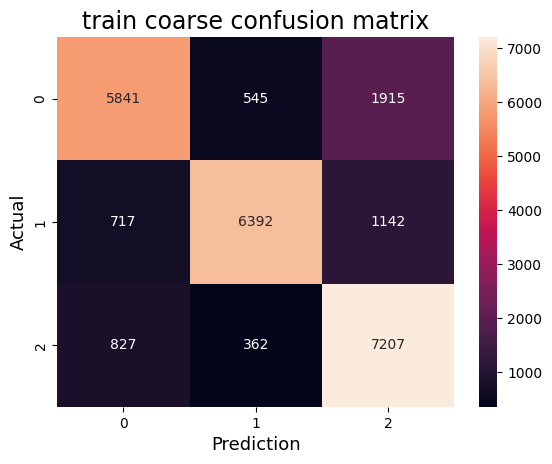

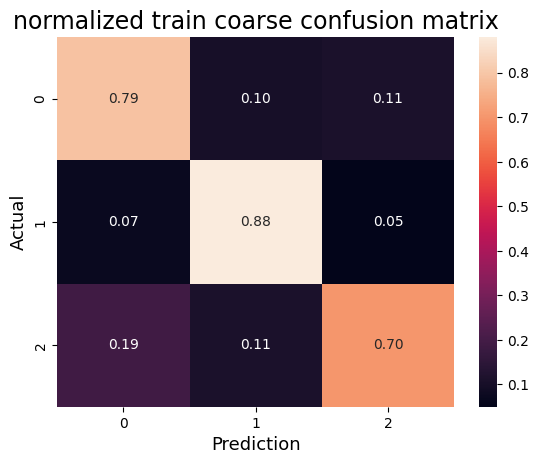

avg_acc 79.0


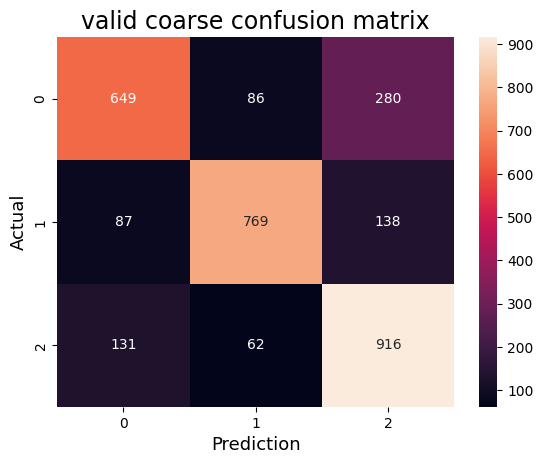

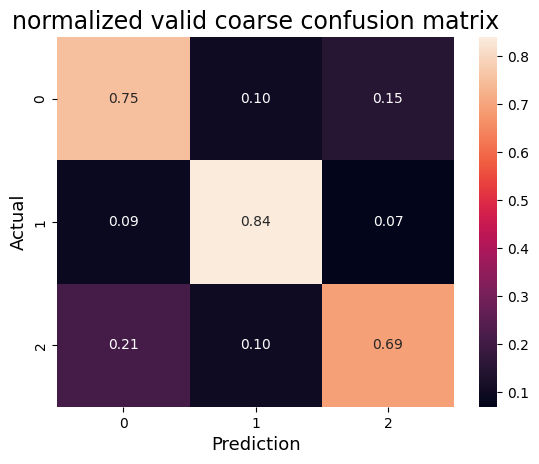

avg_acc 75.99999999999999


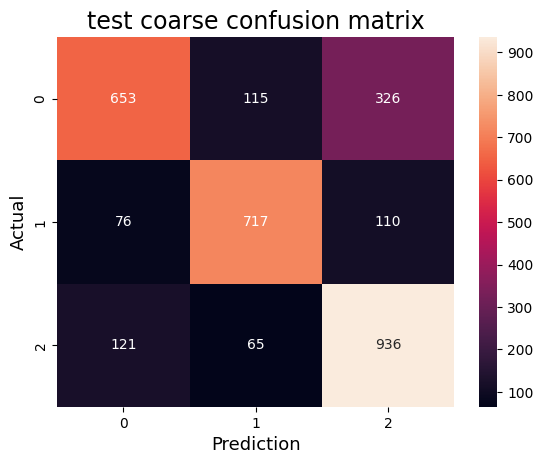

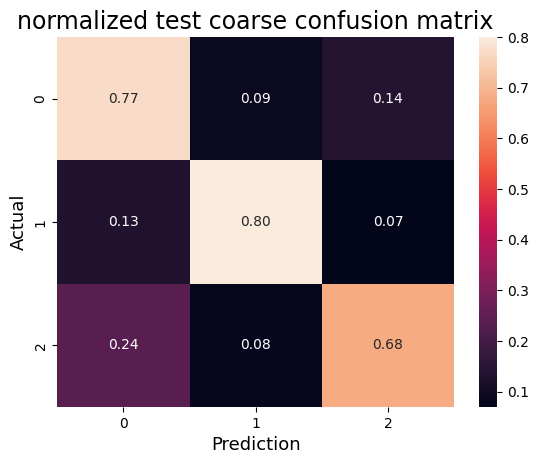

avg_acc 75.0
epoch: 12
train started
train finished
epoch: 13
train started
train finished
epoch: 14
train started
train finished


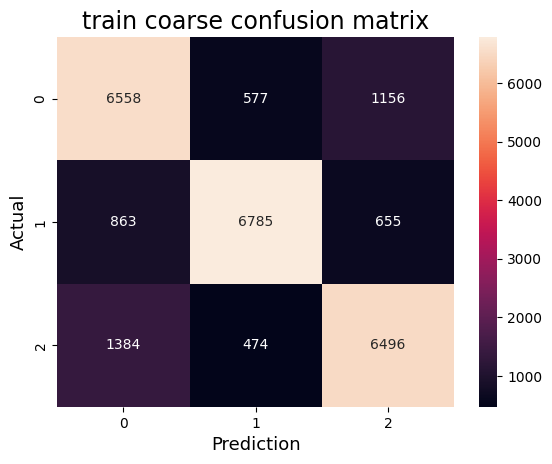

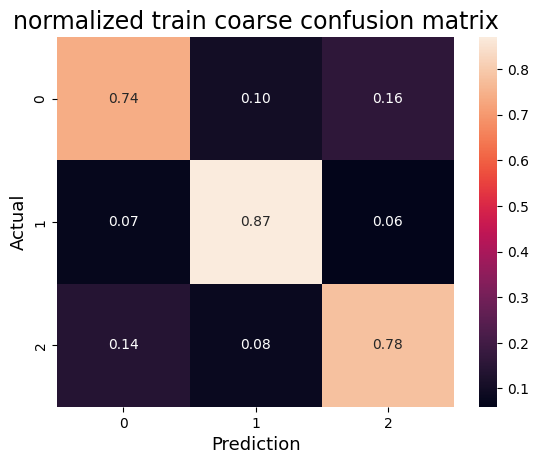

avg_acc 79.66666666666666


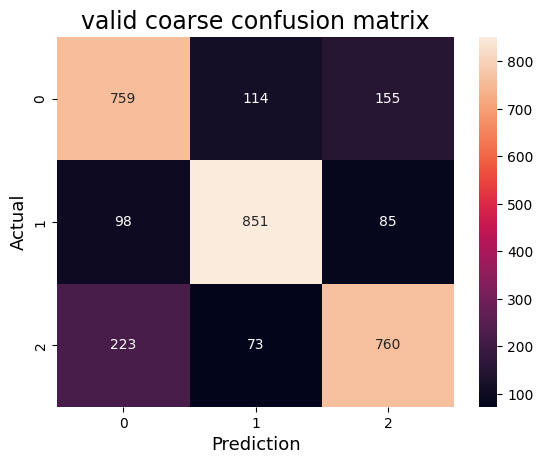

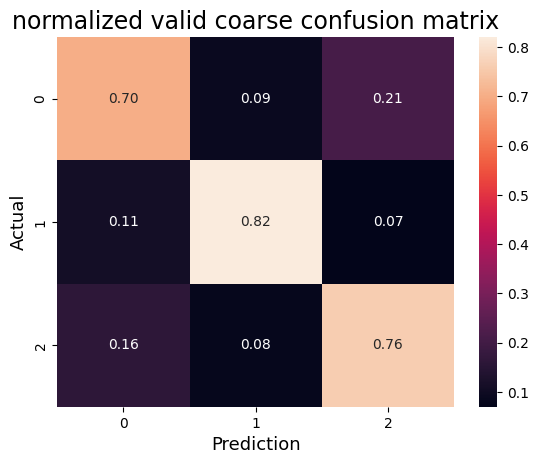

avg_acc 76.00000000000001


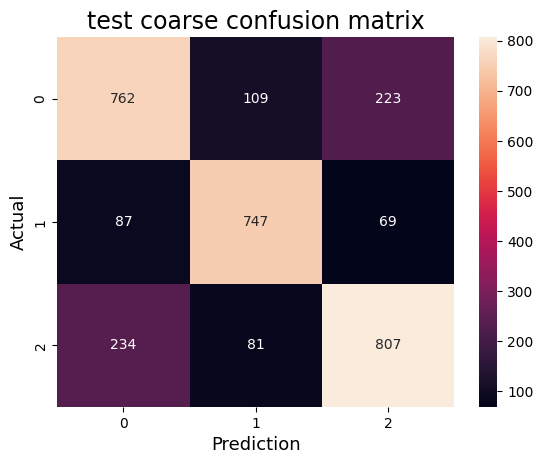

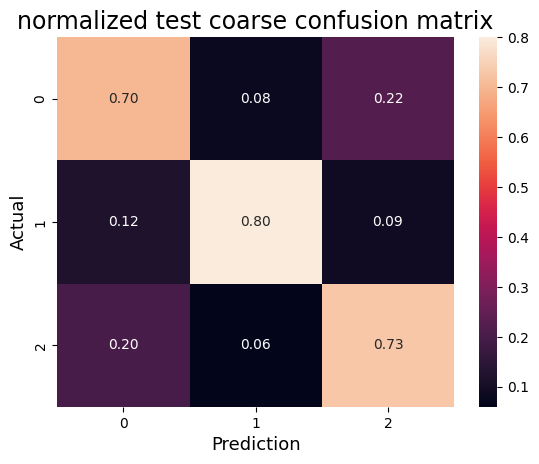

avg_acc 74.33333333333333


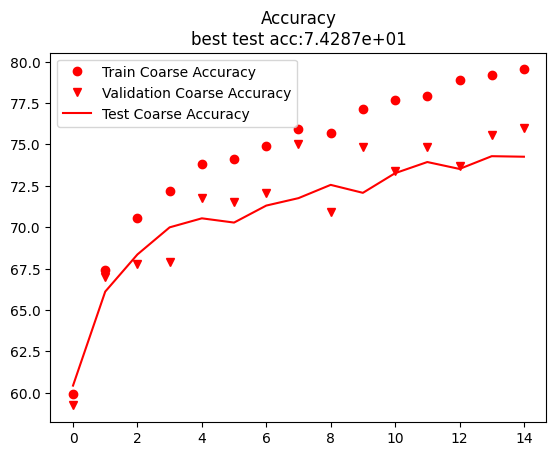

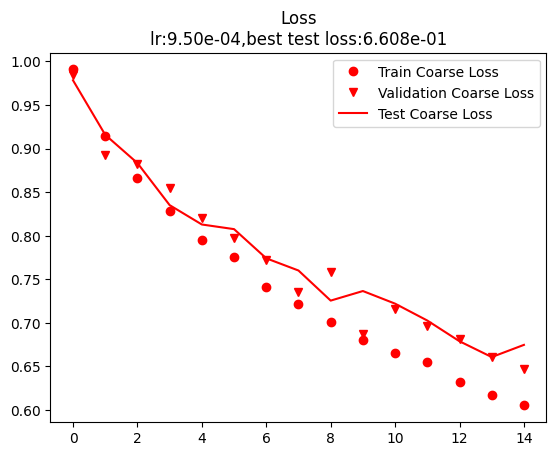

epoch: 15
train started
train finished
epoch: 16
train started
train finished
epoch: 17
train started
train finished


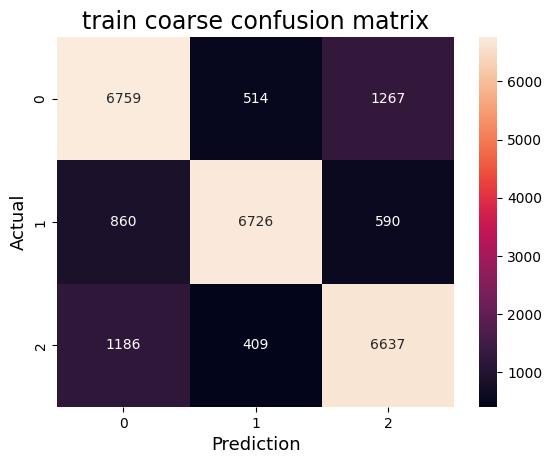

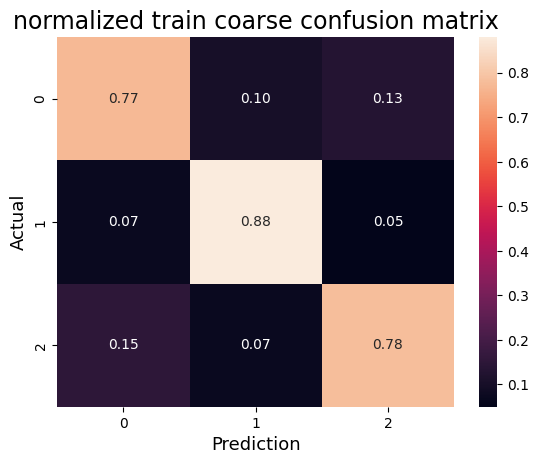

avg_acc 80.99999999999999


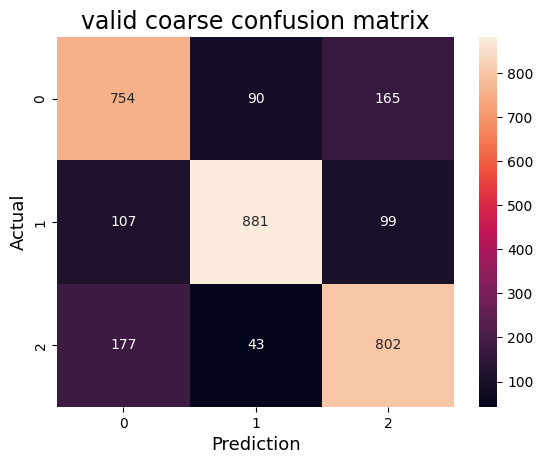

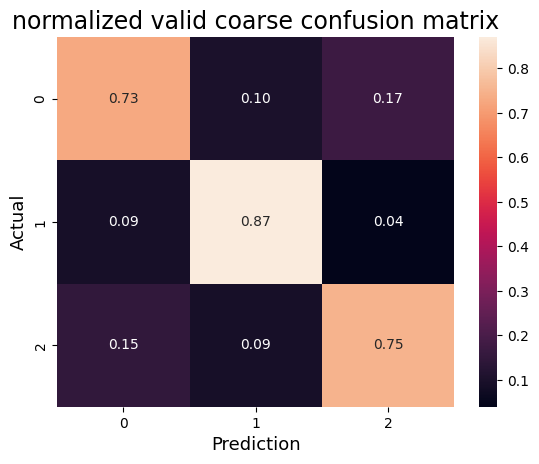

avg_acc 78.33333333333333


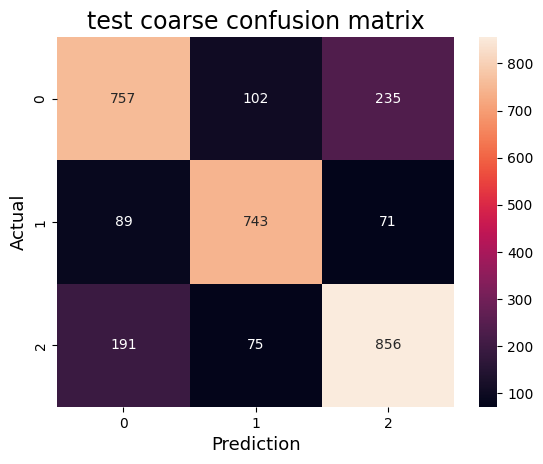

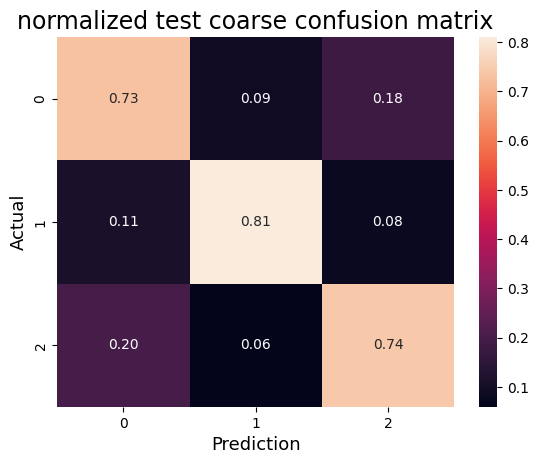

avg_acc 76.00000000000001
epoch: 18
train started
train finished
epoch: 19
train started
train finished


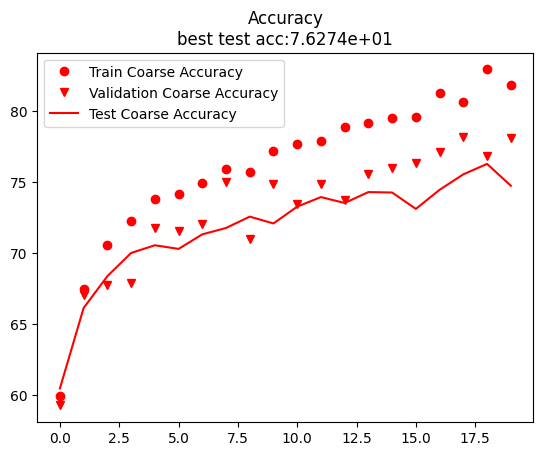

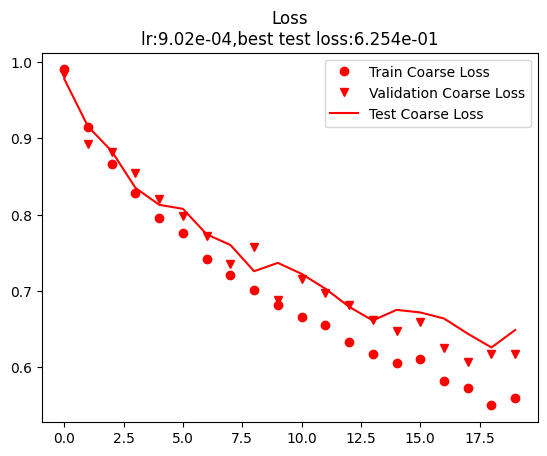

epoch: 20
train started
train finished


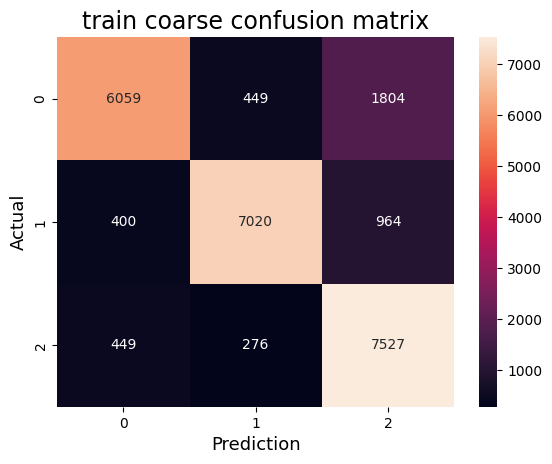

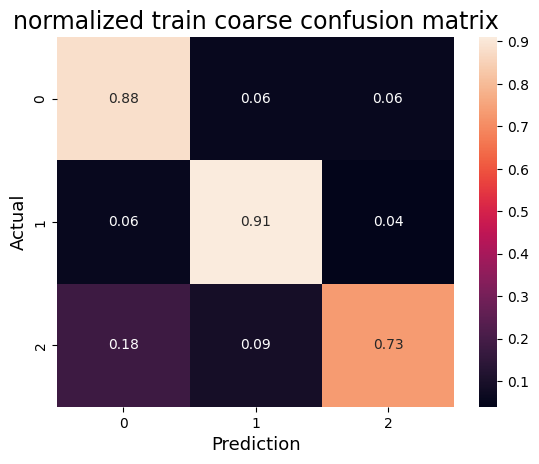

avg_acc 84.0


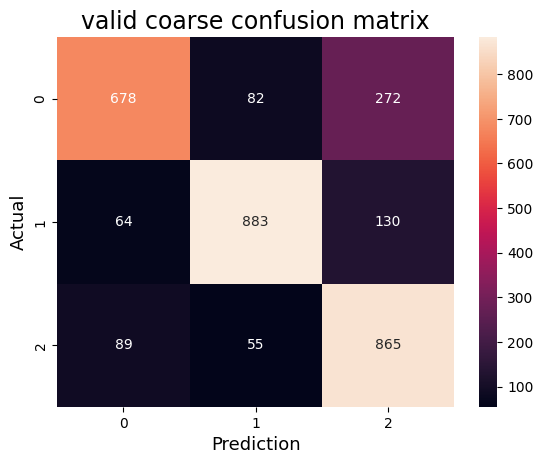

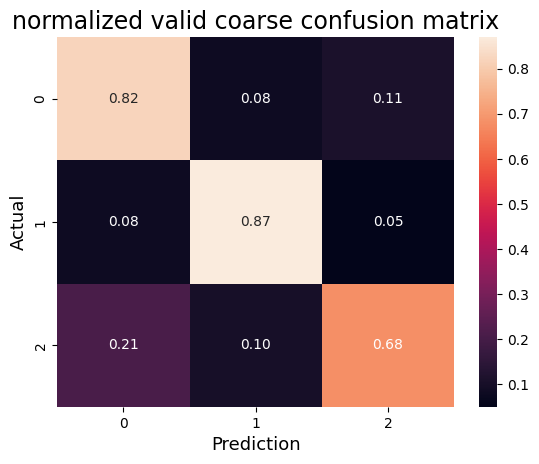

avg_acc 79.0


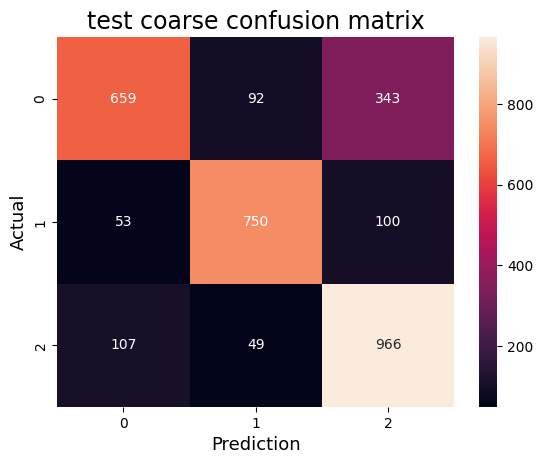

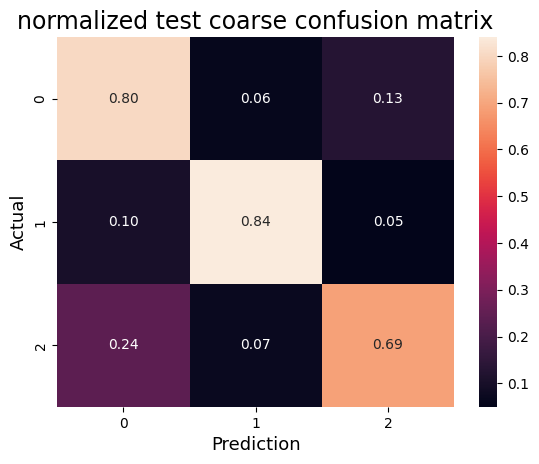

avg_acc 77.66666666666667
epoch: 21
train started
train finished
epoch: 22
train started
train finished
epoch: 23
train started
train finished


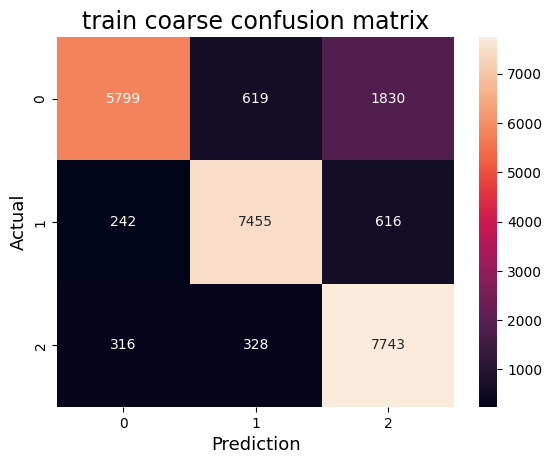

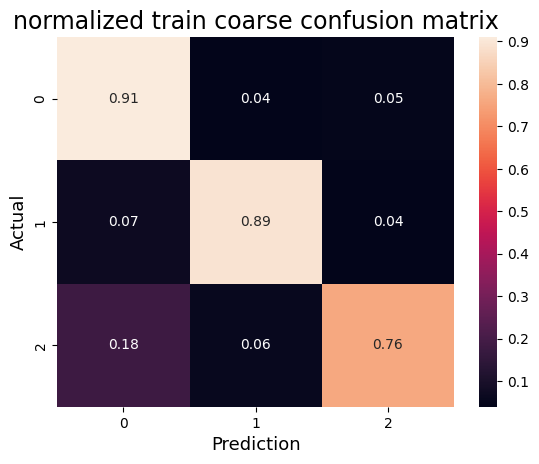

avg_acc 85.33333333333333


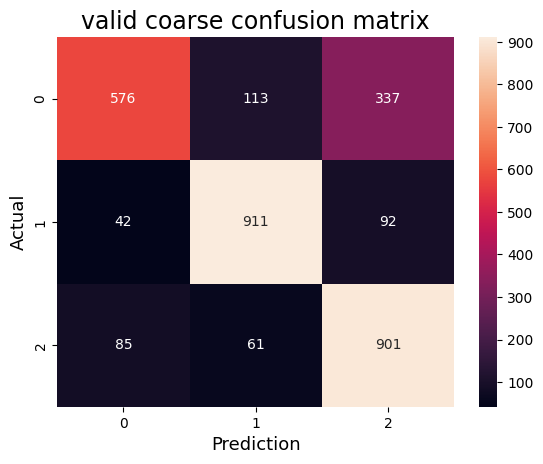

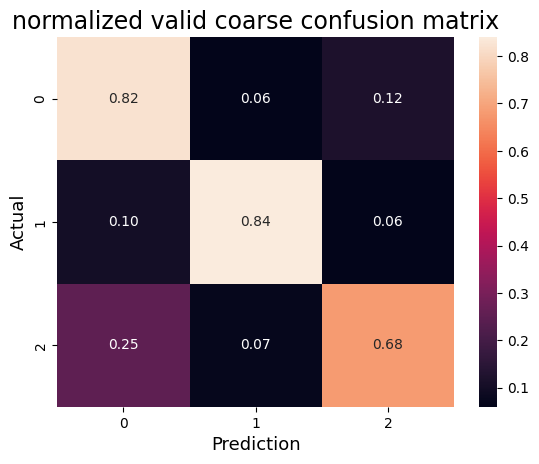

avg_acc 78.0


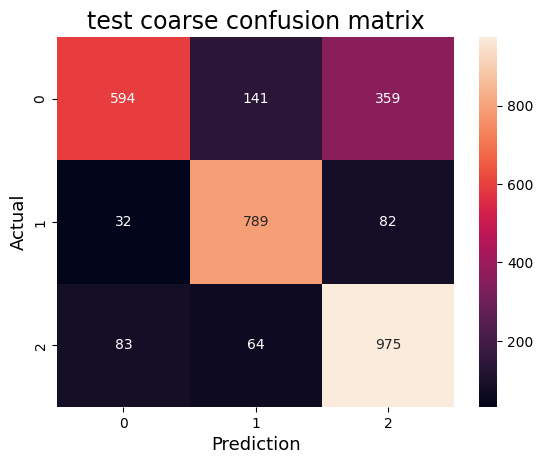

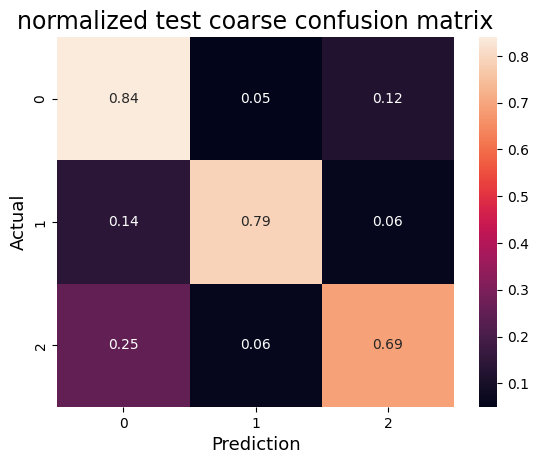

avg_acc 77.33333333333333
epoch: 24
train started
train finished


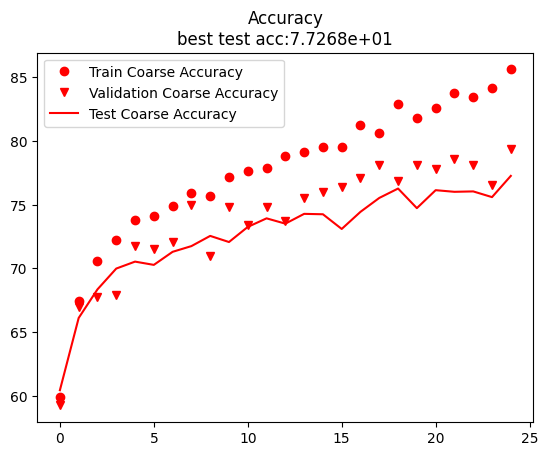

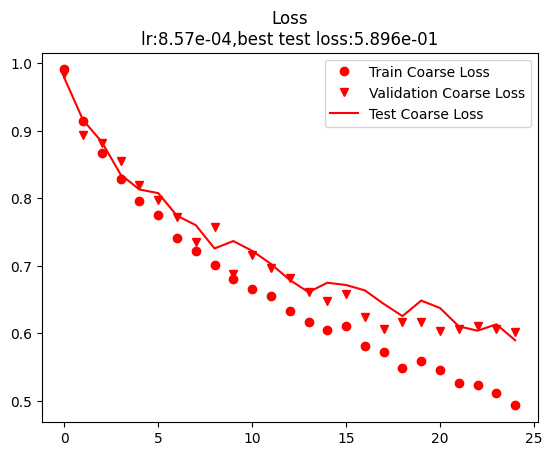

epoch: 25
train started
train finished
epoch: 26
train started
train finished


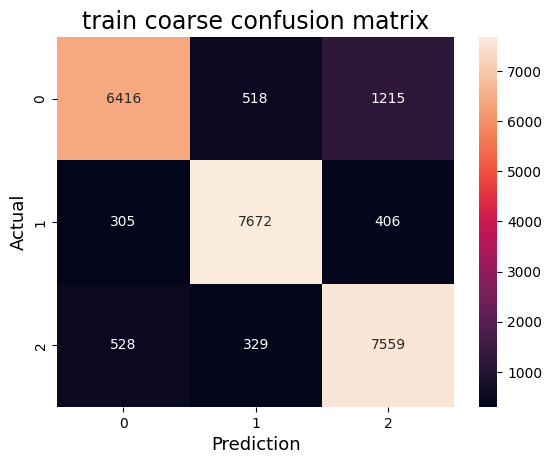

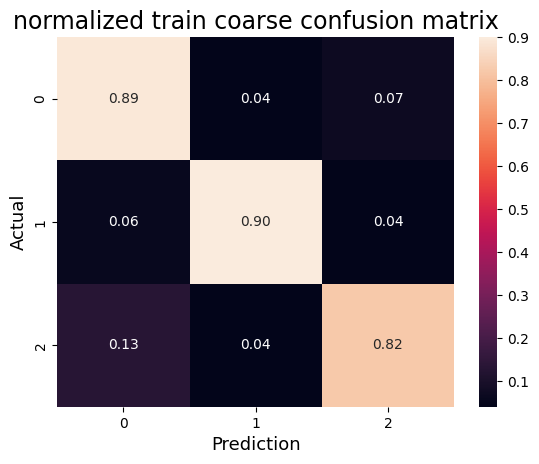

avg_acc 87.0


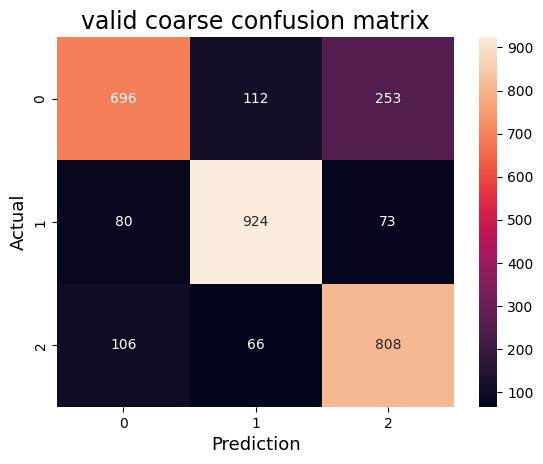

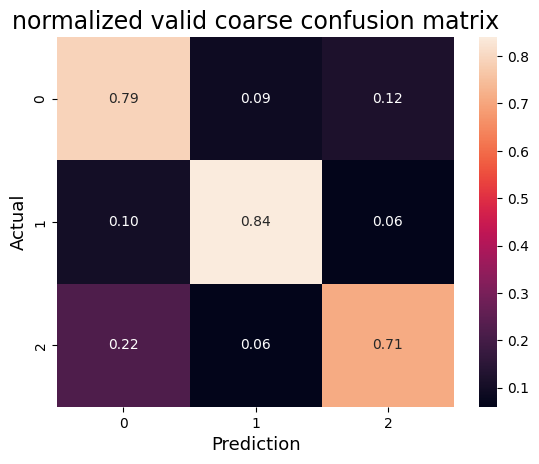

avg_acc 78.0


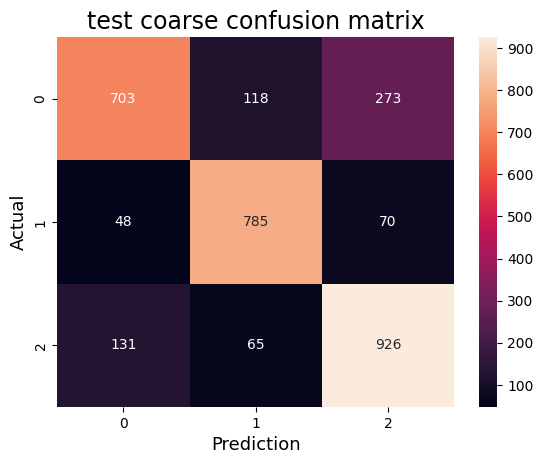

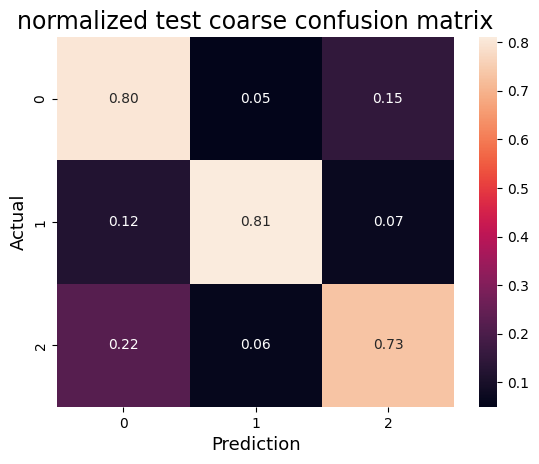

avg_acc 78.0
epoch: 27
train started
train finished
epoch: 28
train started
train finished
epoch: 29
train started
train finished


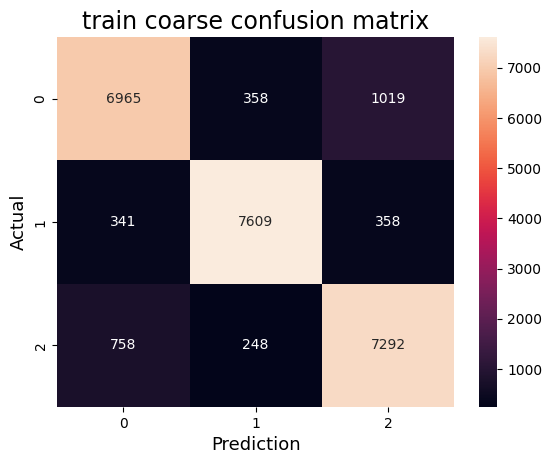

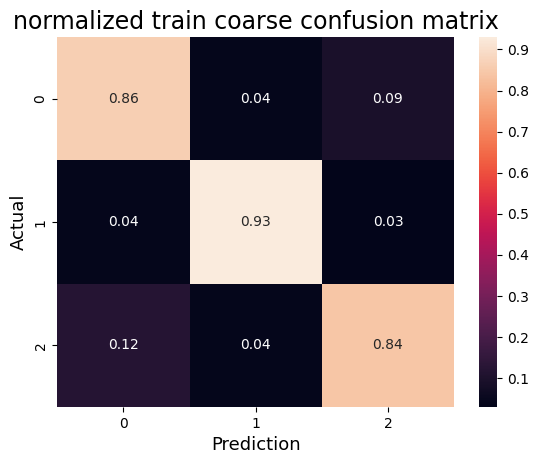

avg_acc 87.66666666666667


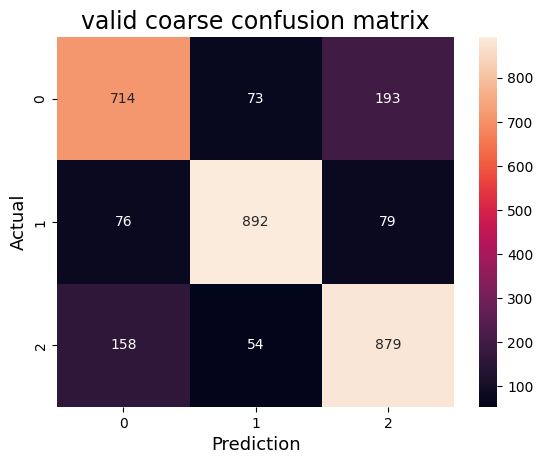

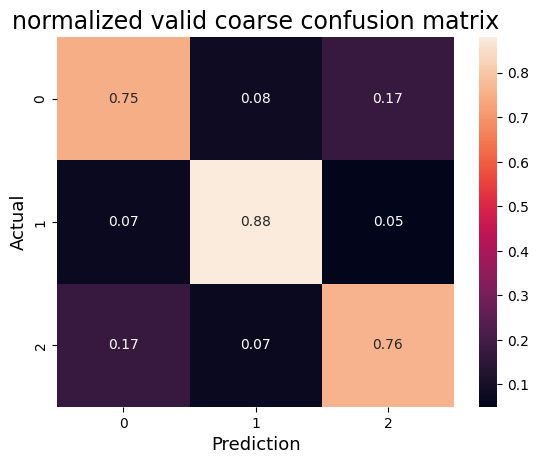

avg_acc 79.66666666666666


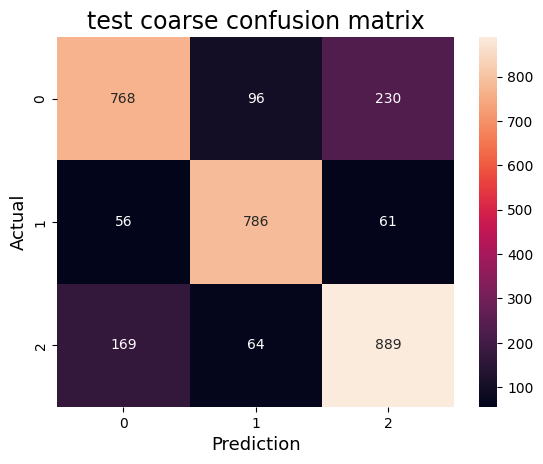

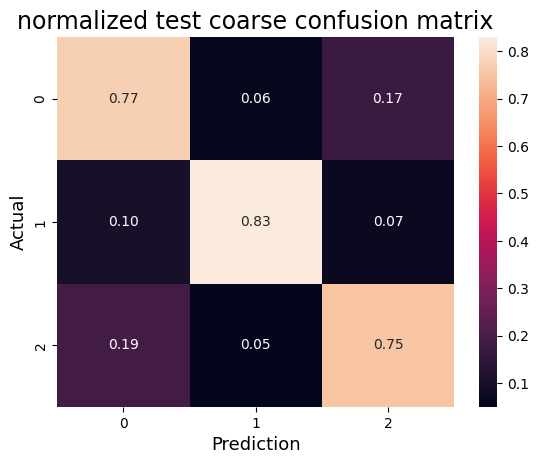

avg_acc 78.33333333333333


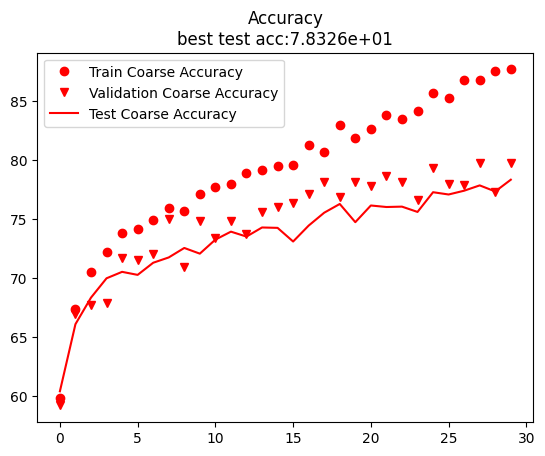

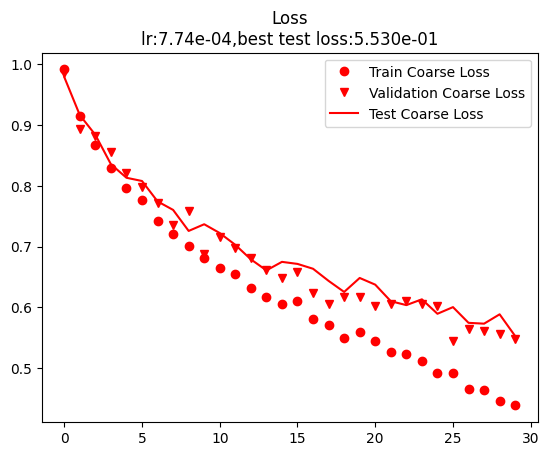

epoch: 30
train started
train finished
epoch: 31
train started
train finished
epoch: 32
train started
train finished


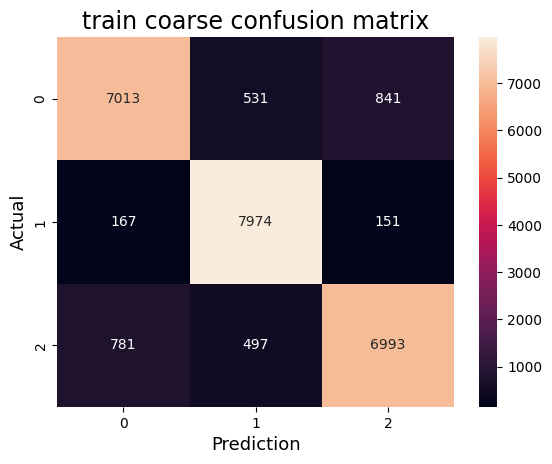

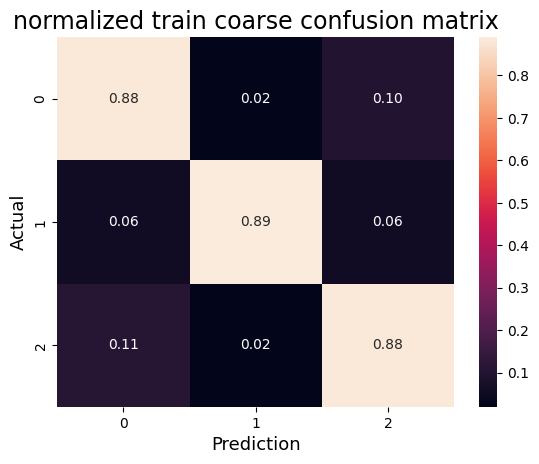

avg_acc 88.33333333333333


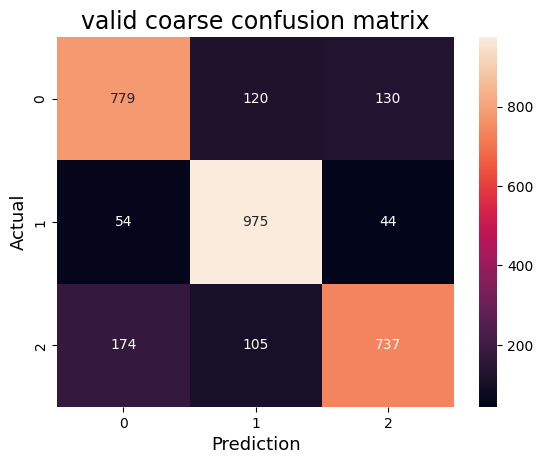

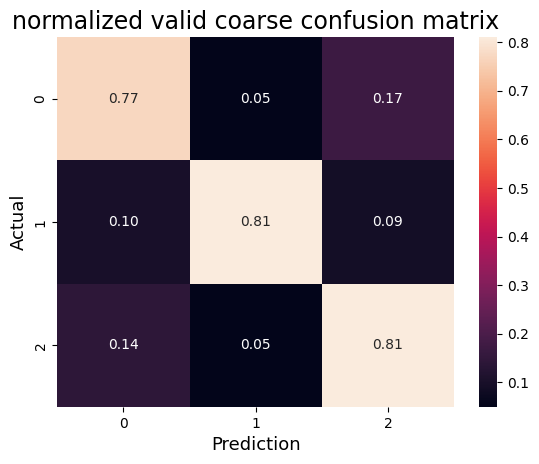

avg_acc 79.66666666666667


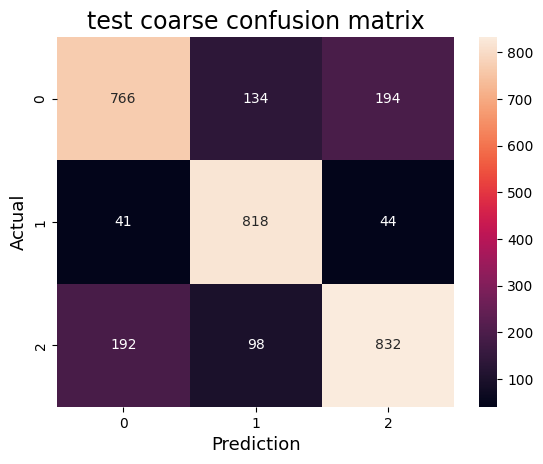

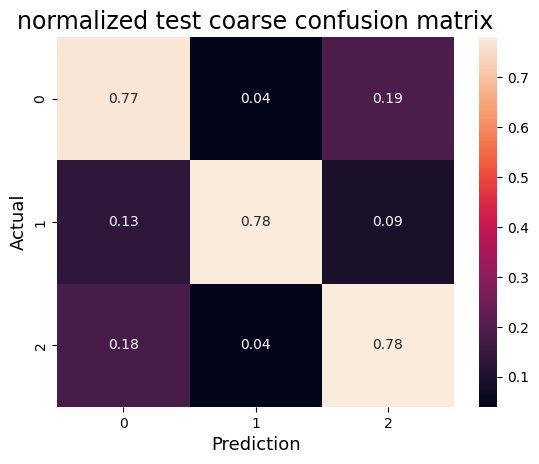

avg_acc 77.66666666666667
epoch: 33
train started
train finished
epoch: 34
train started
train finished


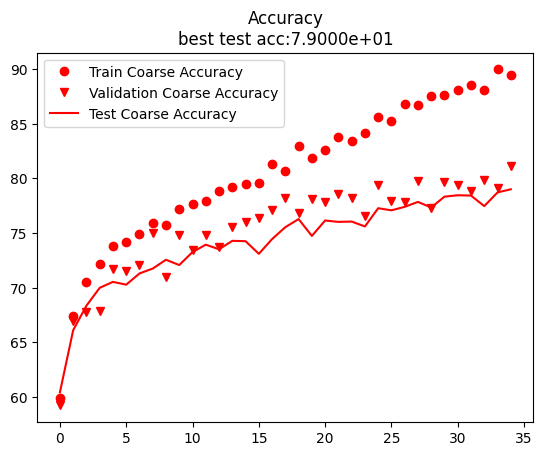

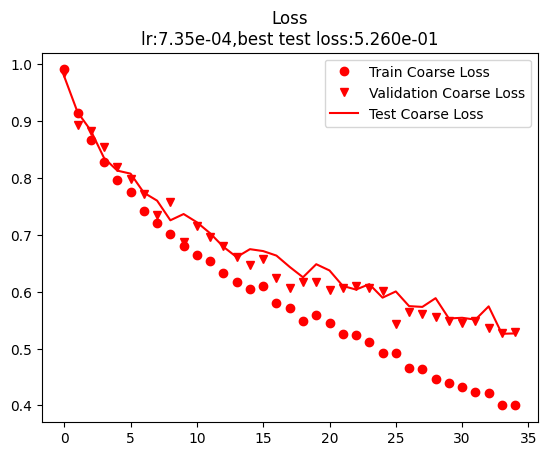

epoch: 35
train started
train finished


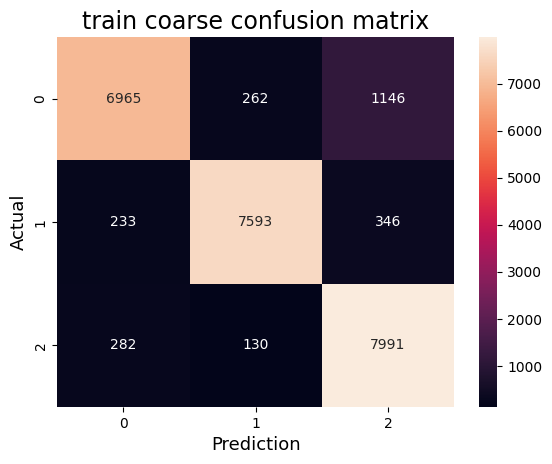

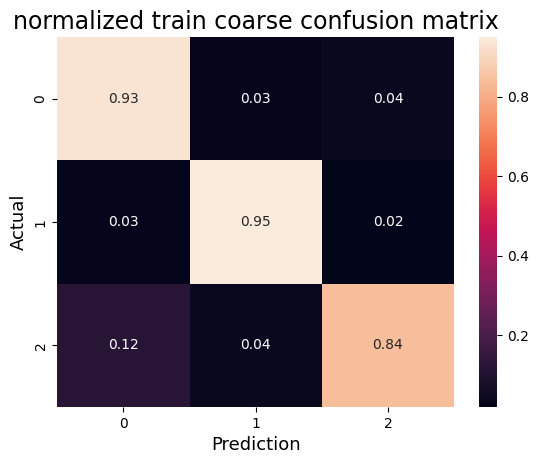

avg_acc 90.66666666666667


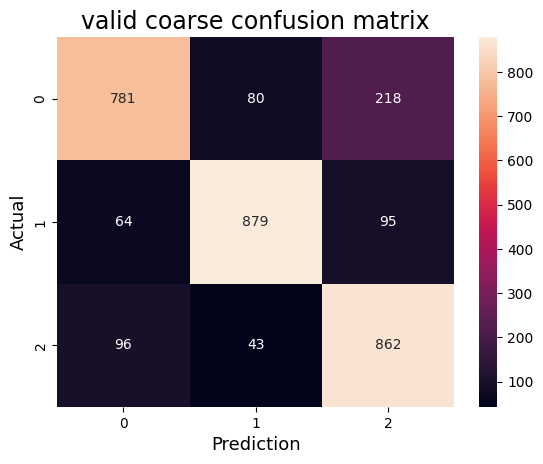

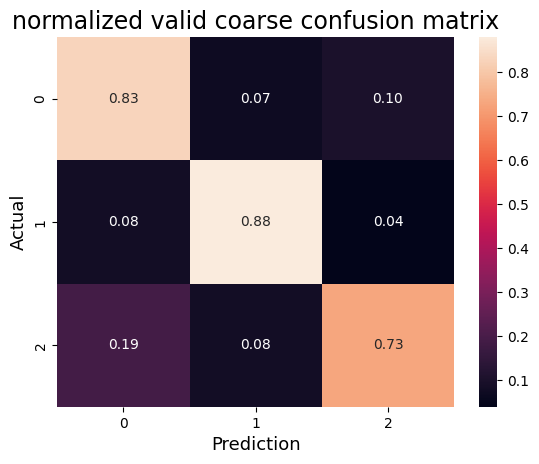

avg_acc 81.33333333333333


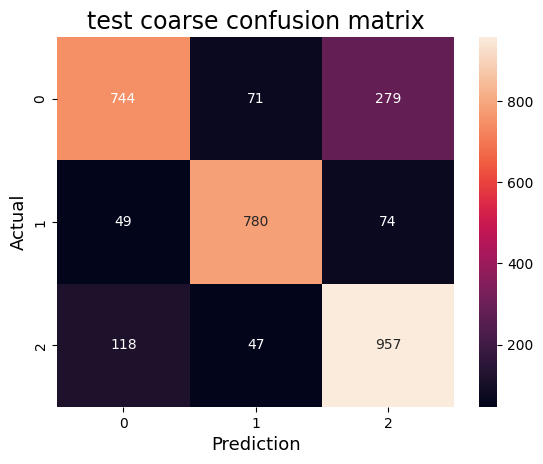

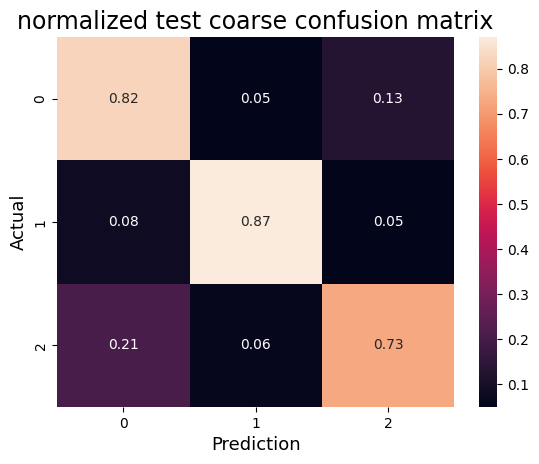

avg_acc 80.66666666666667
epoch: 36
train started
train finished
epoch: 37
train started
train finished
epoch: 38
train started
train finished


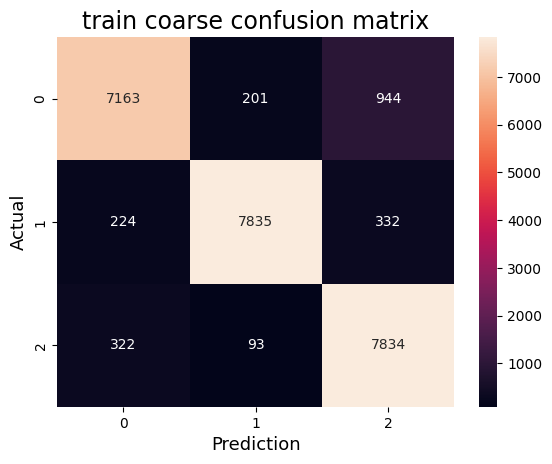

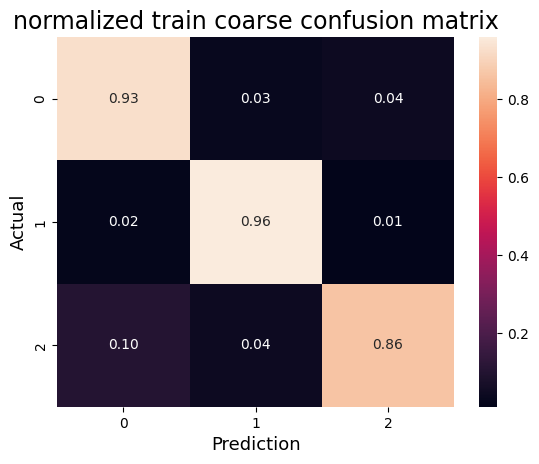

avg_acc 91.66666666666667


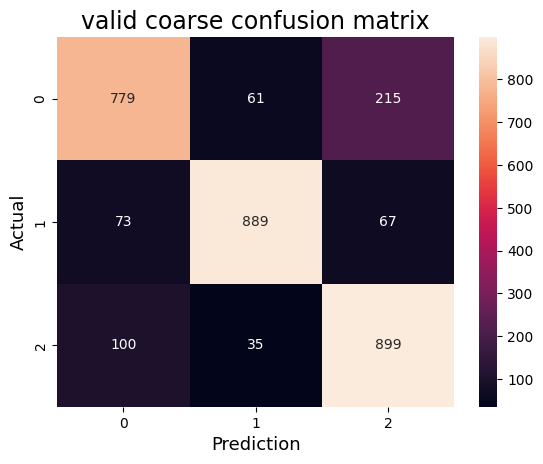

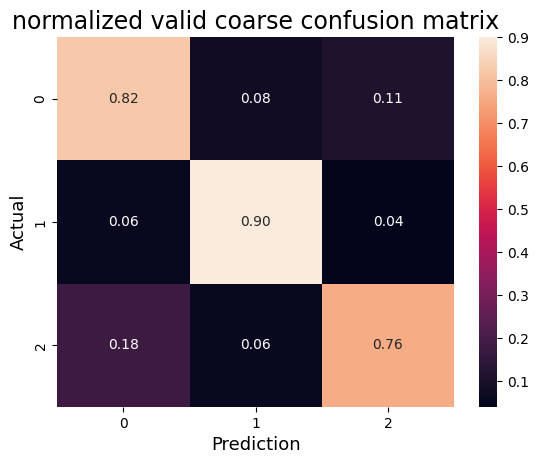

avg_acc 82.66666666666667


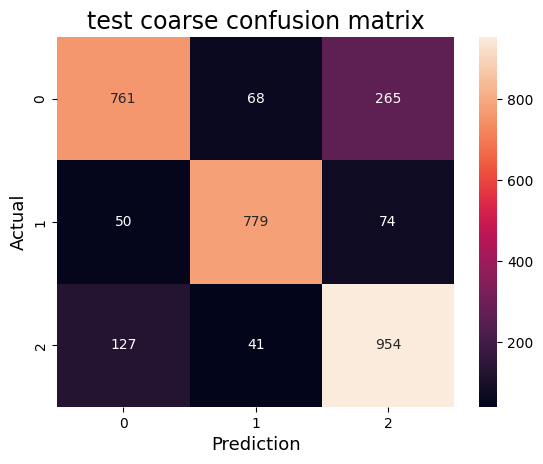

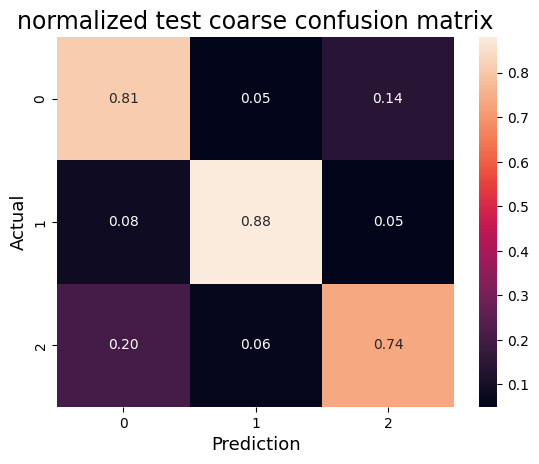

avg_acc 80.99999999999999
epoch: 39
train started
train finished


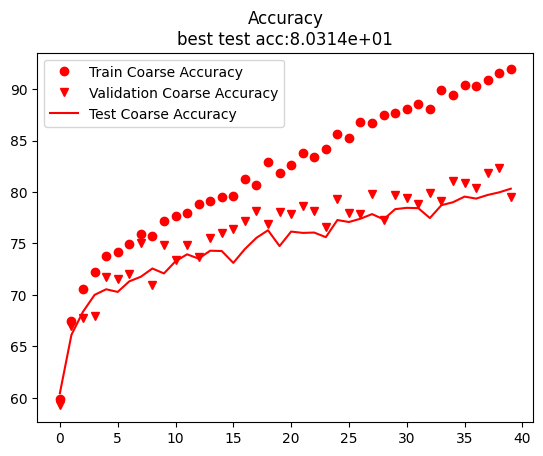

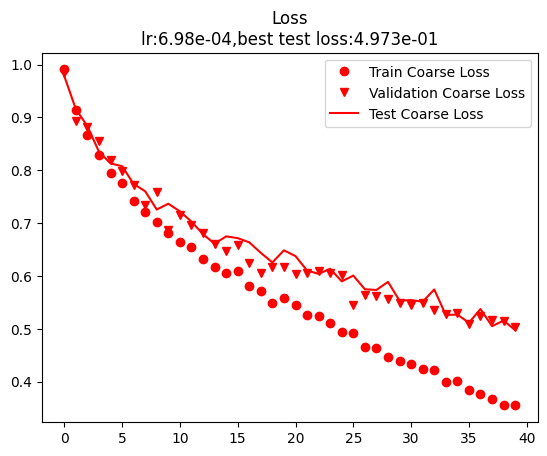

epoch: 40
train started
train finished
epoch: 41
train started
train finished


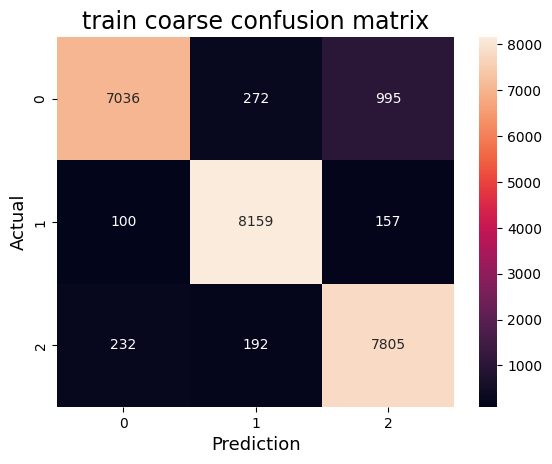

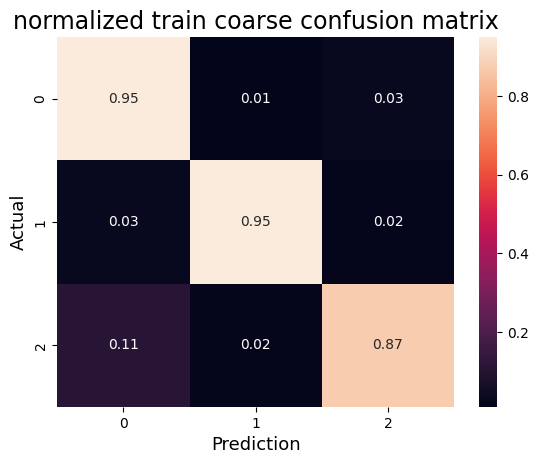

avg_acc 92.33333333333333


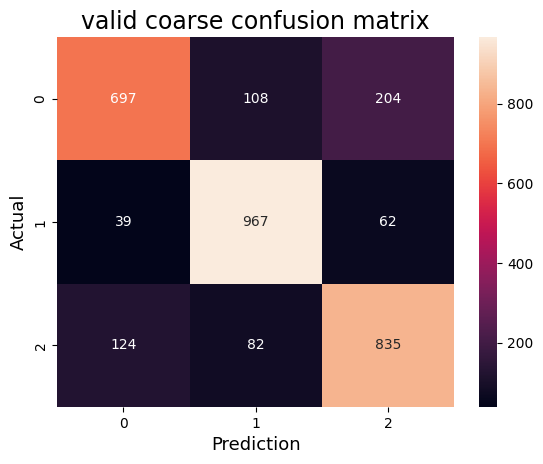

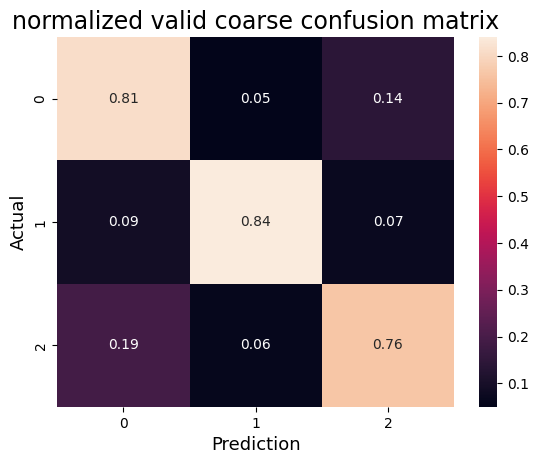

avg_acc 80.33333333333333


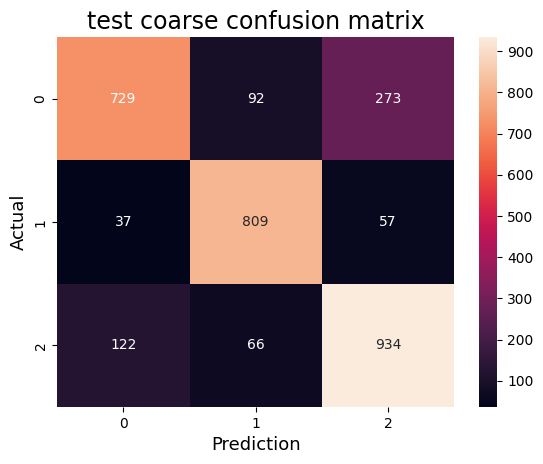

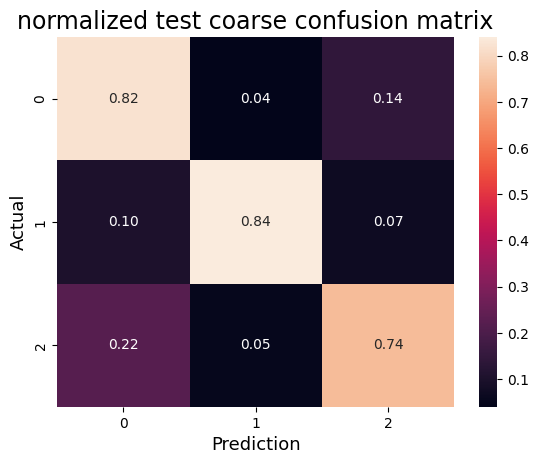

avg_acc 80.0
epoch: 42
train started
train finished
epoch: 43
train started
train finished
epoch: 44
train started
train finished


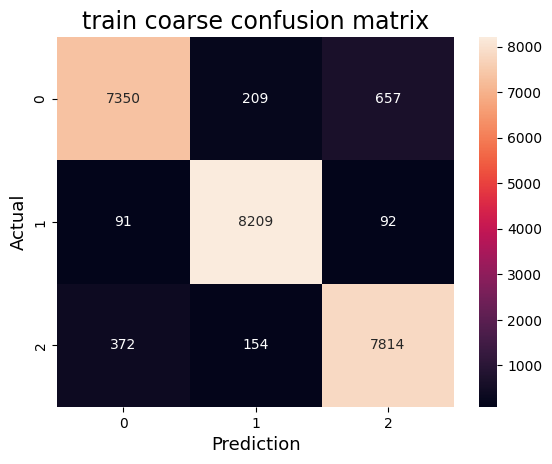

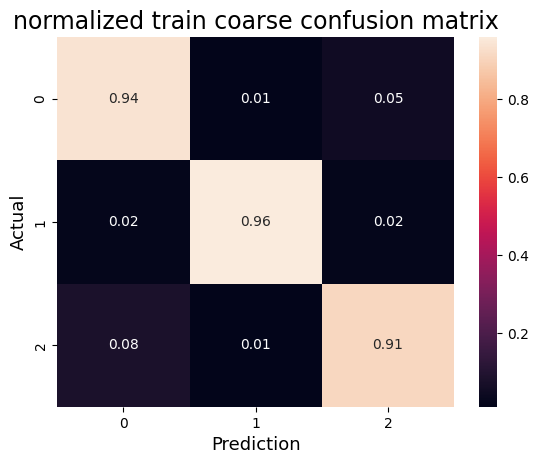

avg_acc 93.66666666666667


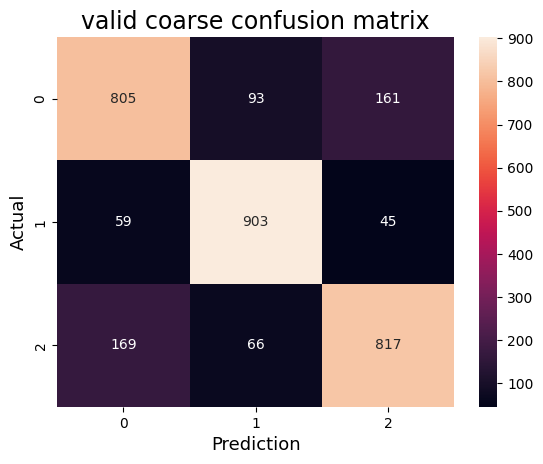

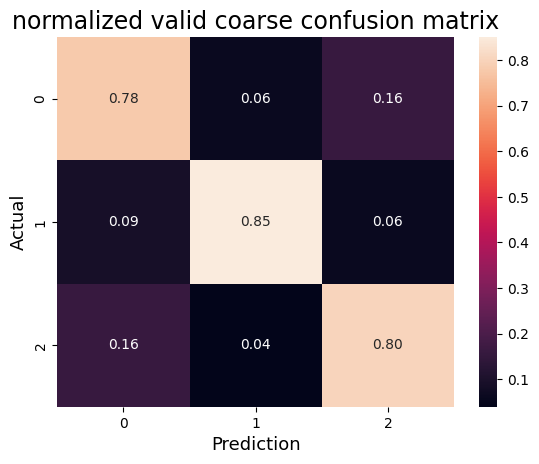

avg_acc 80.99999999999999


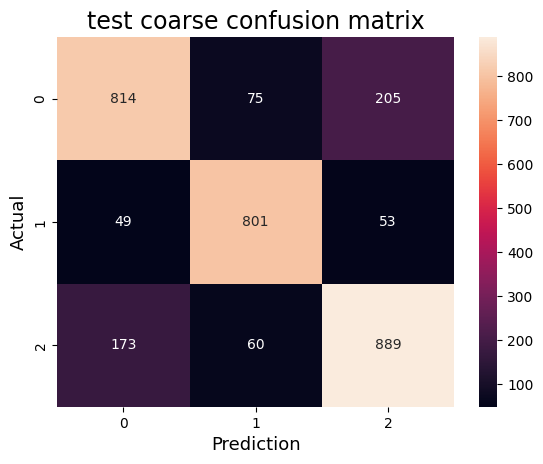

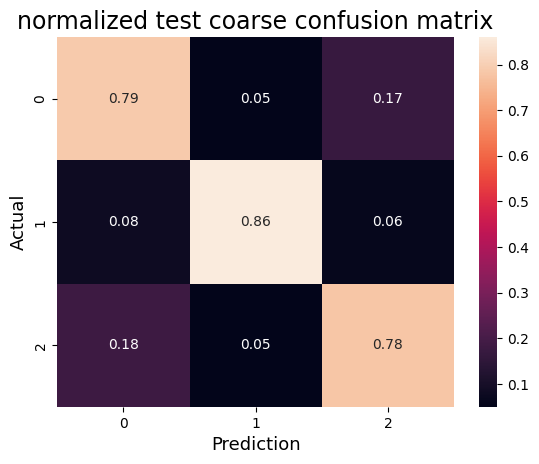

avg_acc 80.99999999999999


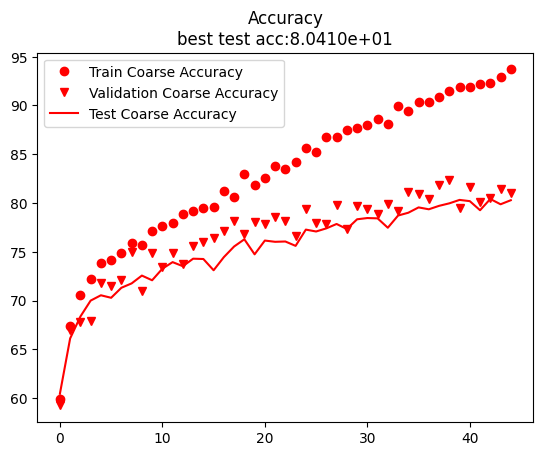

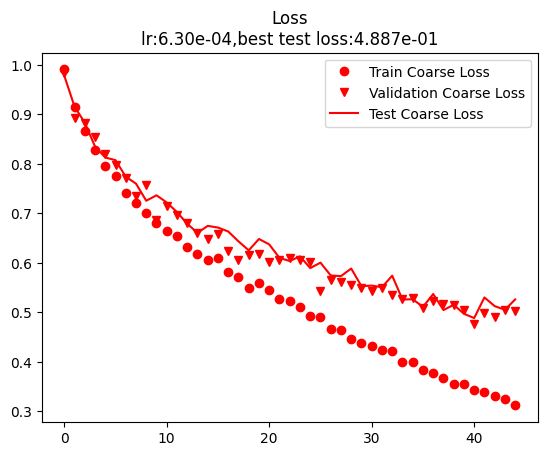

epoch: 45
train started
train finished
epoch: 46
train started
train finished
epoch: 47
train started
train finished


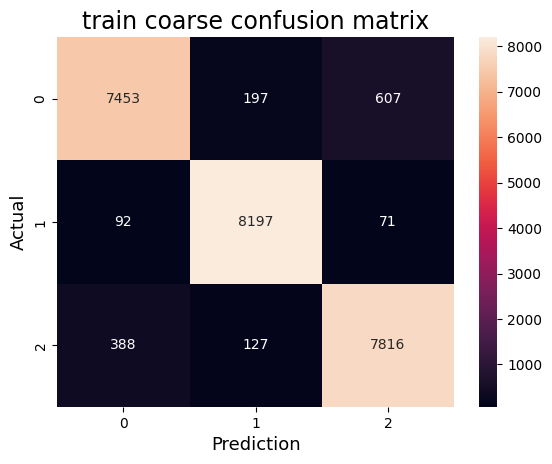

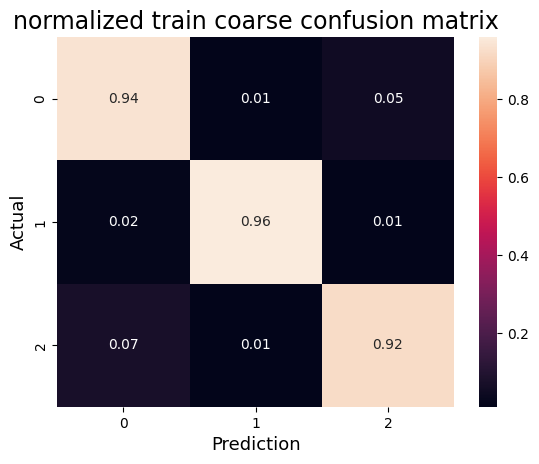

avg_acc 94.0


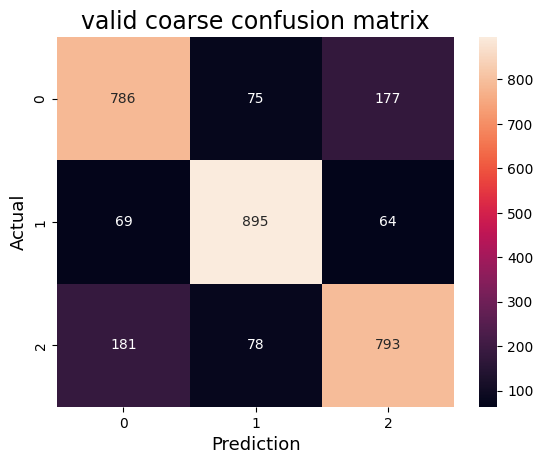

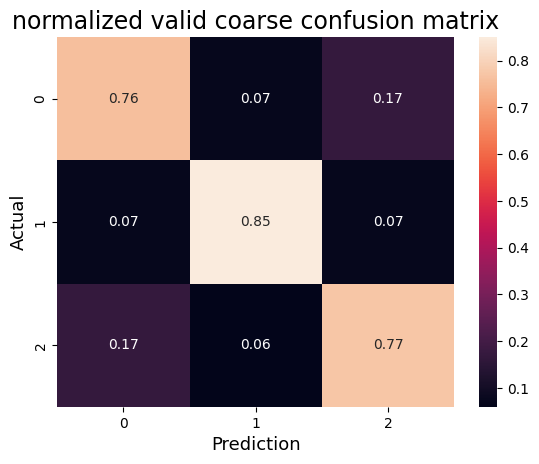

avg_acc 79.33333333333333


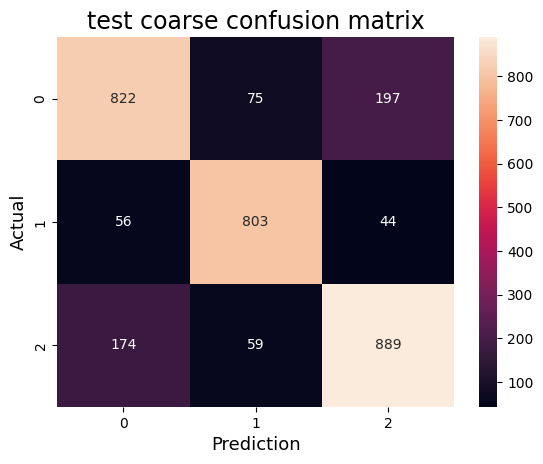

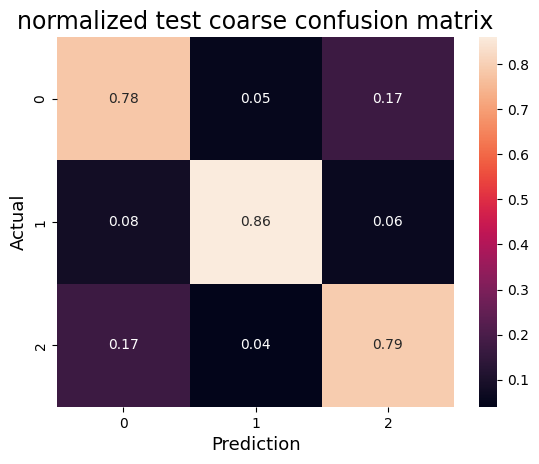

avg_acc 81.00000000000001
epoch: 48
train started
train finished
epoch: 49
train started
train finished


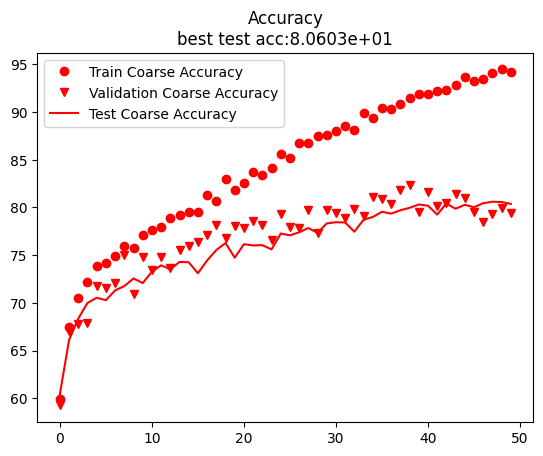

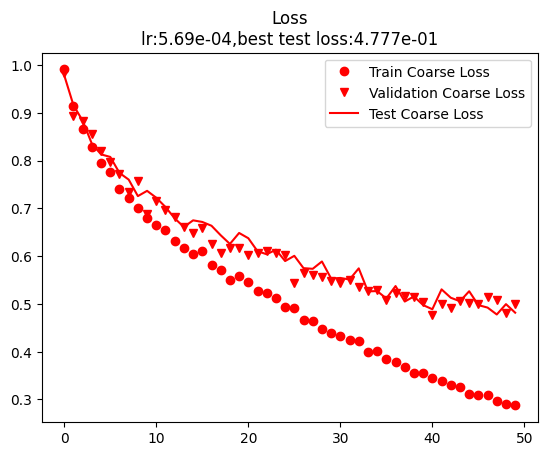

epoch: 50
train started
train finished


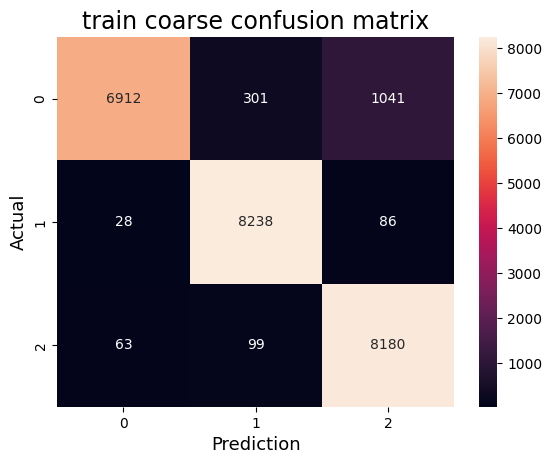

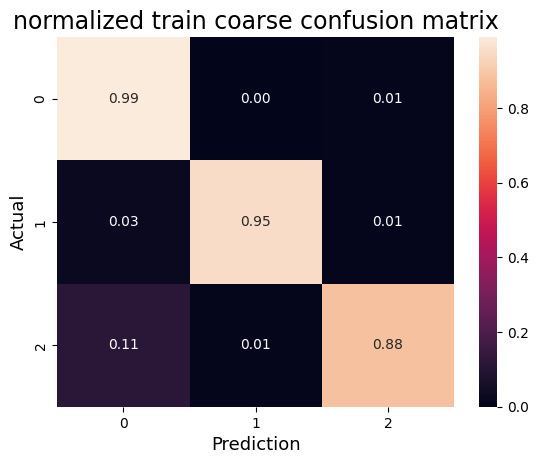

avg_acc 94.0


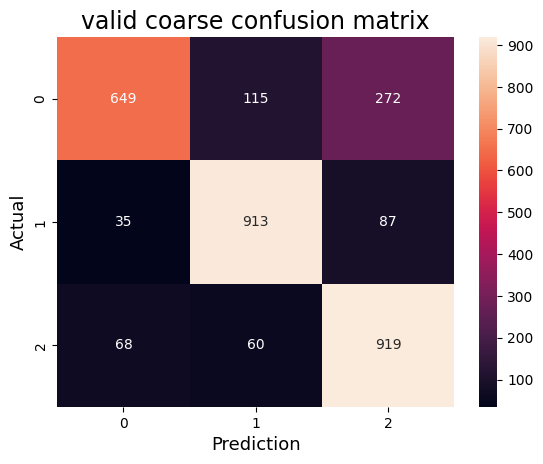

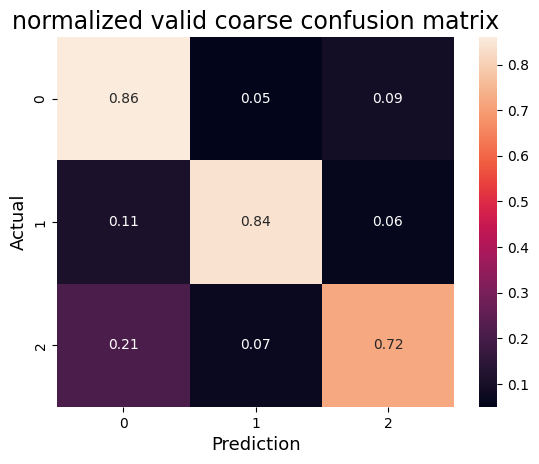

avg_acc 80.66666666666667


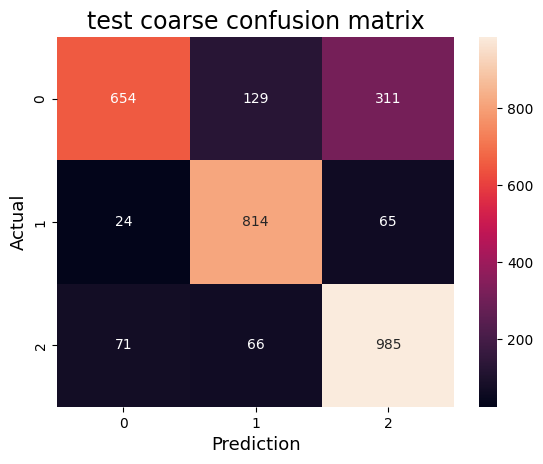

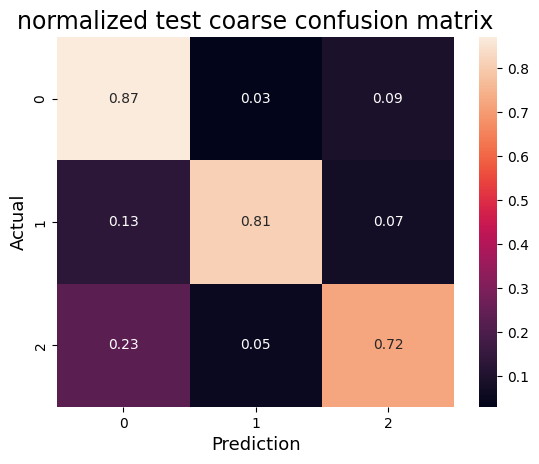

avg_acc 80.00000000000001
epoch: 51
train started
train finished
epoch: 52
train started
train finished
epoch: 53
train started
train finished


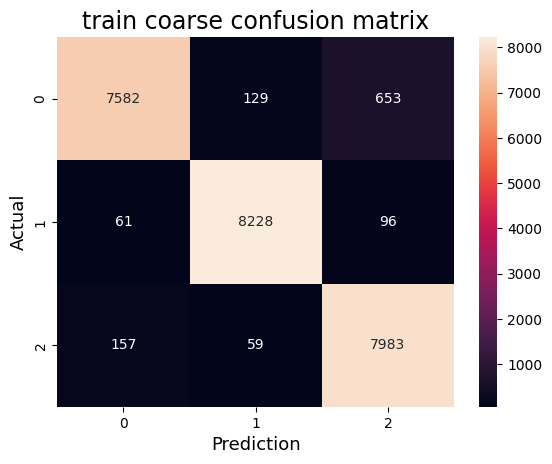

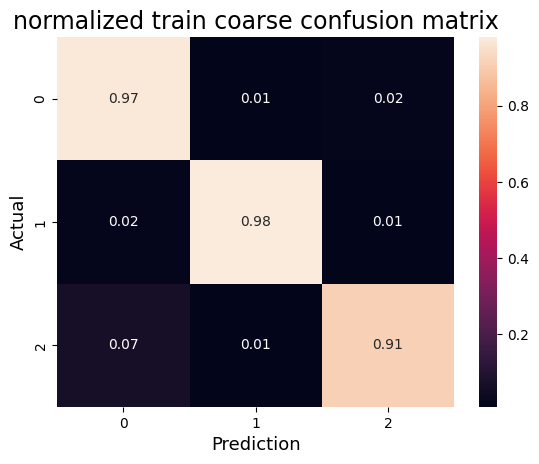

avg_acc 95.33333333333333


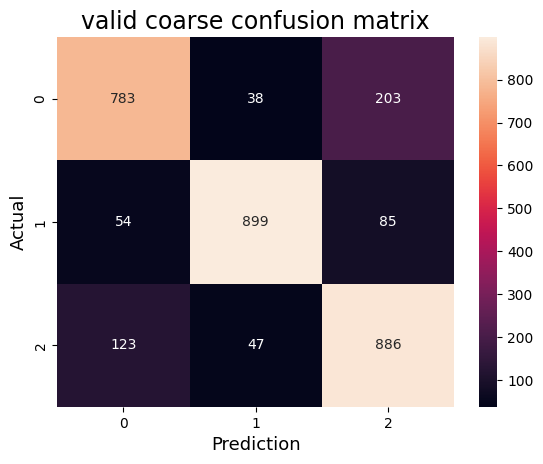

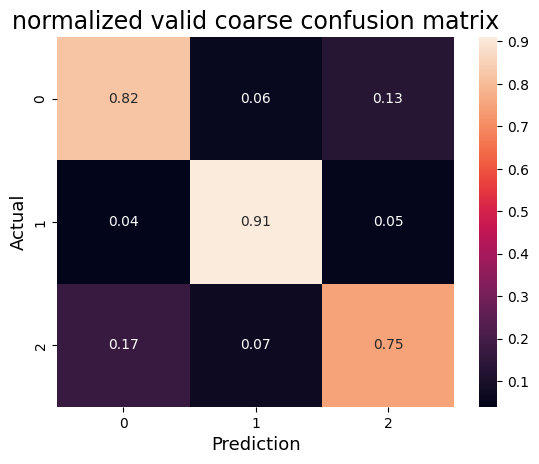

avg_acc 82.66666666666667


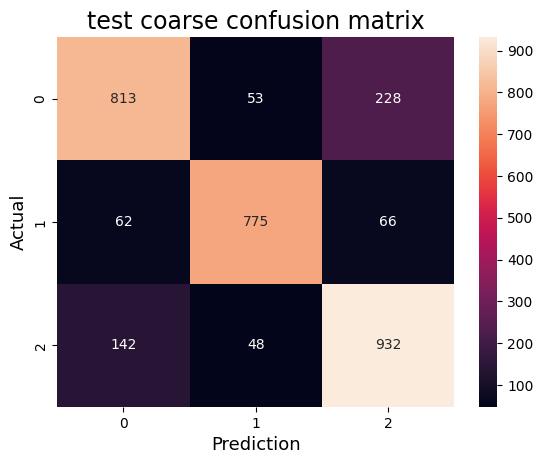

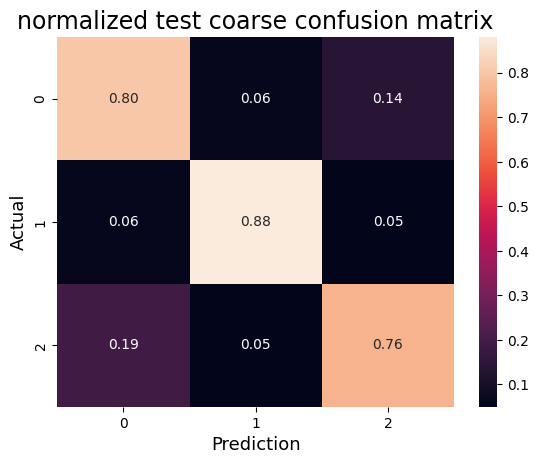

avg_acc 81.33333333333334
epoch: 54
train started
train finished


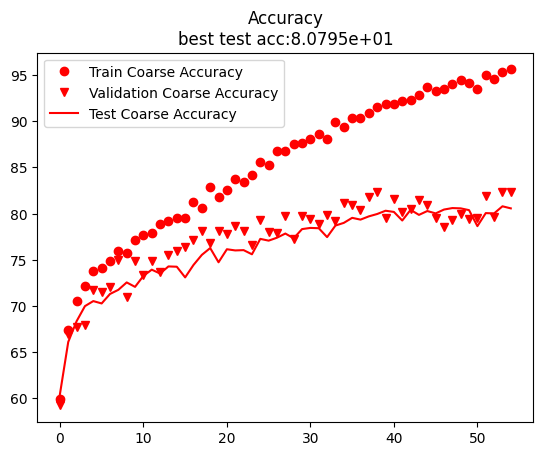

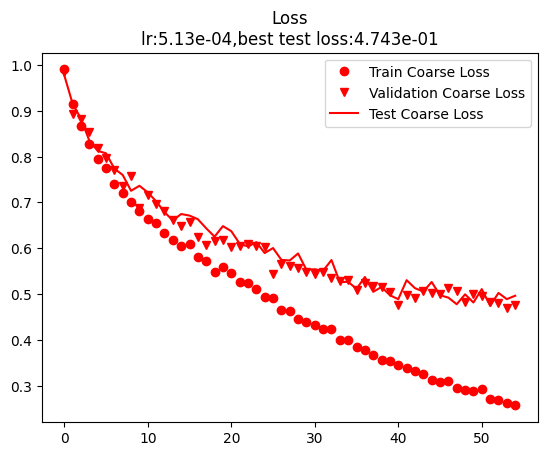

epoch: 55
train started
train finished
epoch: 56
train started
train finished


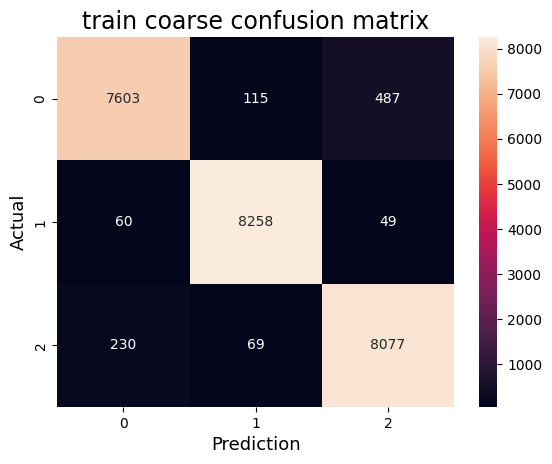

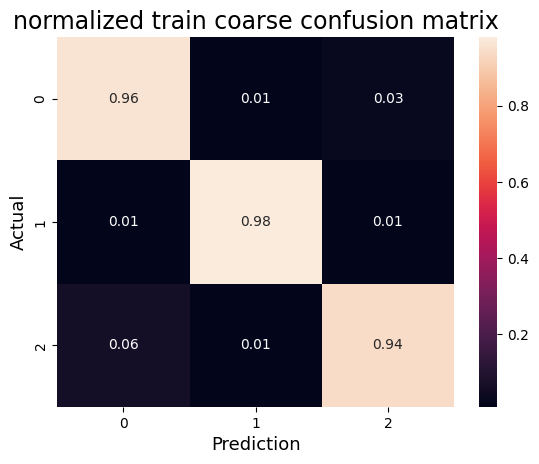

avg_acc 96.0


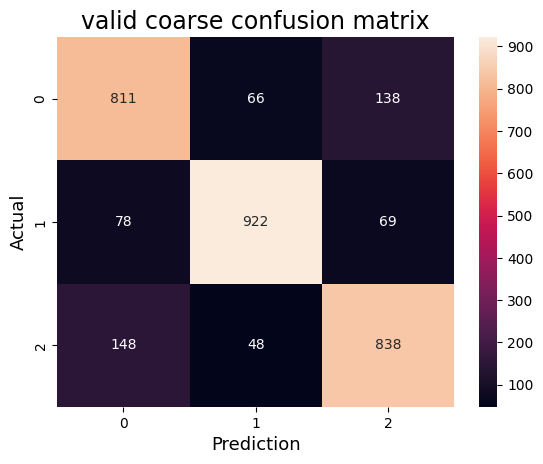

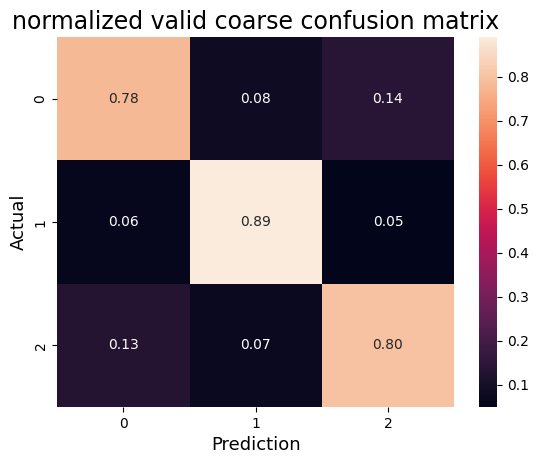

avg_acc 82.33333333333333


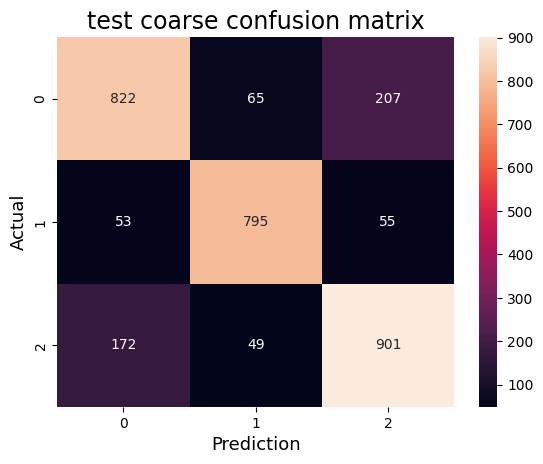

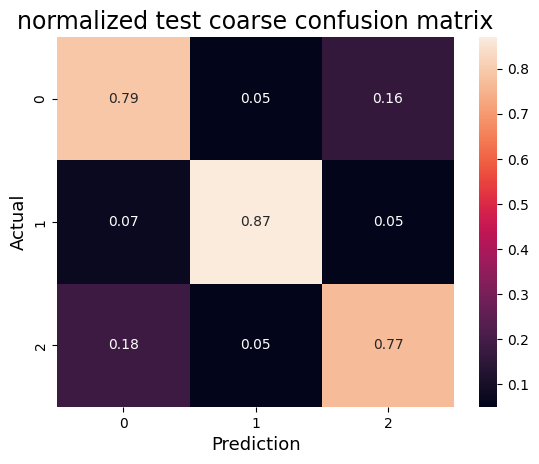

avg_acc 81.00000000000001
epoch: 57
train started
train finished
epoch: 58
train started
train finished
epoch: 59
train started
train finished


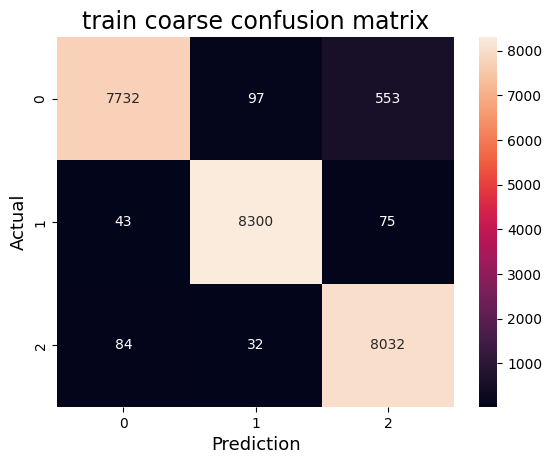

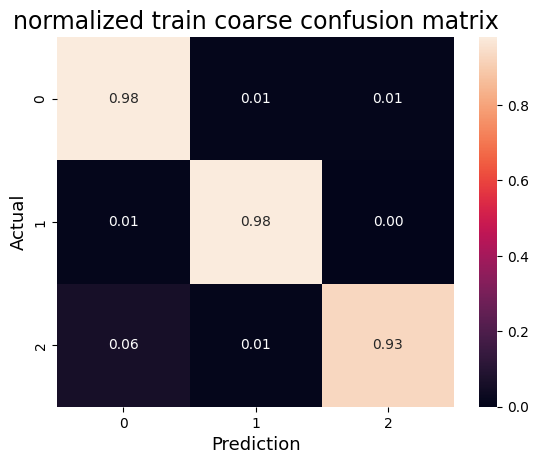

avg_acc 96.33333333333333


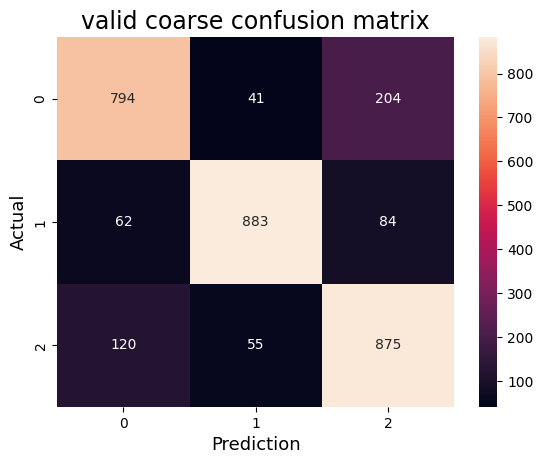

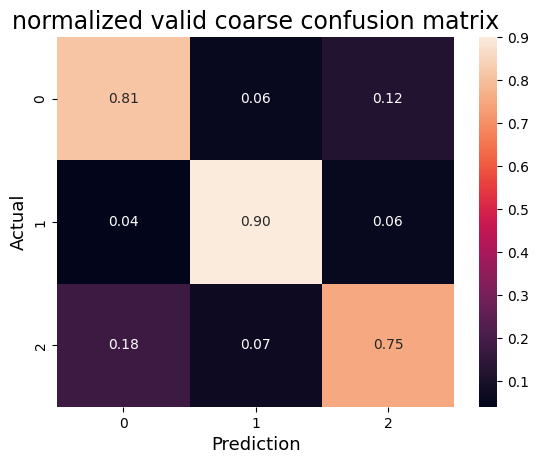

avg_acc 82.0


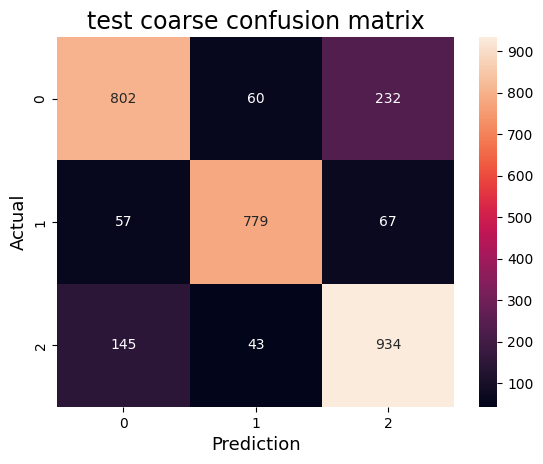

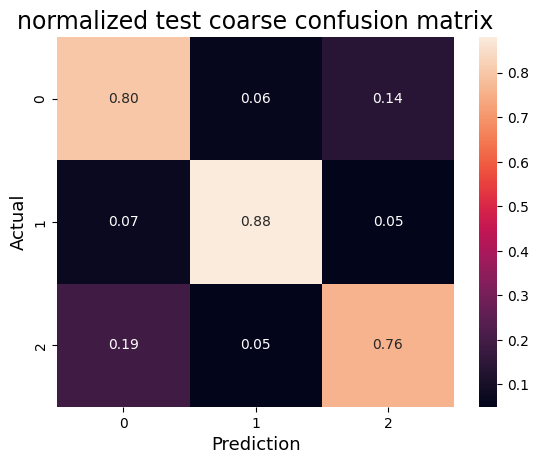

avg_acc 81.33333333333334


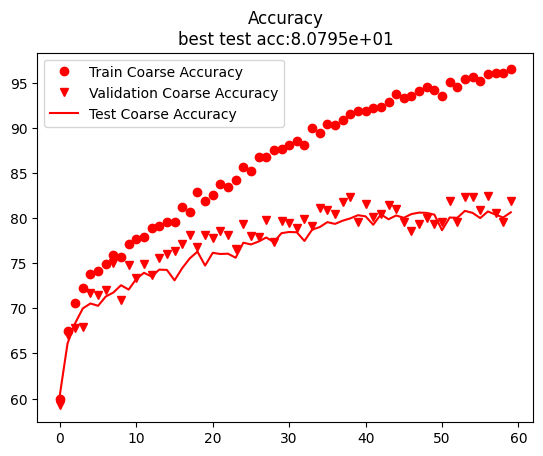

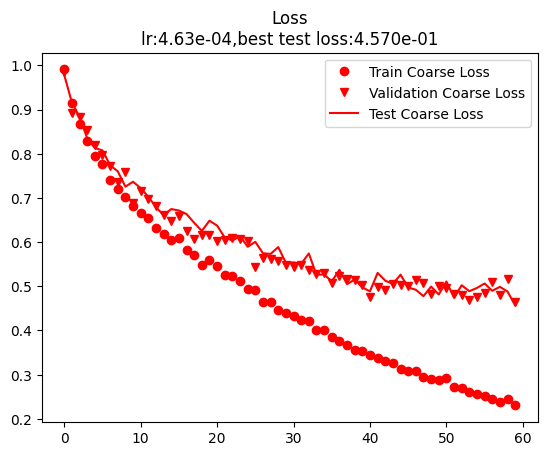

epoch: 60
train started


In [ ]:
coarse_classifier_model.train_model(num_epochs=epochs,dataloader_dict=dataloader_dict['coarse'])

In [ ]:
torch.save(combined_model.checkpoint['model_state_dict'],'model.pth')

### eval all

In [ ]:
import pickle
file_name='0.5 0.25 1.pkl'
with open(file_name, 'wb') as file:

    # A new file will be created
    pickle.dump(combined_model.loss_acc_info, file)

In [ ]:
combined_model.loss_acc_info

In [ ]:
from google.colab import files

dfs_names=['ferplus']
dataloader_train , dataloader_valid = get_dataloaders(dfs_names,32)


combined_model = torch.load('coarse model.pth')
fine_model = torch.load('fine model.pth')

(22884, 48, 48)
imgs.shape=(18307, 48, 48),len(emotion_lbls)=18307,len(coarse_lbls)=18307,len(fine_lbls)=18307
imgs.shape=(4577, 48, 48),len(emotion_lbls)=4577,len(coarse_lbls)=4577,len(fine_lbls)=4577


In [ ]:

dl_type='train'




dataloader=dataloader_dict[dl_type]
plot_name=f"{str('-'.join(dfs_names))} ** {dl_type=} **"

coarse_fine_map={

      '0_0':3,

      '1_0':0,
      '1_1':1,
      '1_2':2,
      '1_3':4,

      '2_0':5,

      '3_0':6
    }

device = torch.device('cuda')
# fine_model=model
combined_model.eval()

n_correct=0
n_data=0

pred_emotion=[]
target_emotion=[]

pred_coarse=[]
target_coarse=[]

pred_fine=[]
target_fine=[]

with torch.no_grad():


    for x,y_emotion,y_coarse,y_fine in dataloader:

        x,y_emotion,y_coarse,y_fine=x.to(device),y_emotion.to(device),y_coarse.to(device),y_fine.to(device)
        coarse_output,fine_output = combined_model(x,is_training=False)

        coarse_fine=list(zip(coarse_output.argmax(axis=1).cpu().numpy(),fine_output.argmax(axis=1).cpu().numpy()))
        n_data+=len(y_coarse)
        for (c,f),ct,ft in zip(coarse_fine, y_coarse.argmax(axis=1).cpu().numpy(), y_fine.argmax(axis=1).cpu().numpy()):



            pred_emotion.append(coarse_fine_map[str(c)+'_'+str(f)])
            target_emotion.append(coarse_fine_map[str(ct)+'_'+str(ft)])

            pred_coarse.append(c)
            target_coarse.append(ct)

            pred_fine.append(f)
            target_fine.append(ft)

            # print(f'{c=},{f=},{ct=},{ft=}')

            if c==ct and f==ft:
                n_correct+=1

acc_emotion=sum(np.array(pred_emotion)==np.array(target_emotion))/n_data
acc_coarse=sum(np.array(pred_coarse)==np.array(target_coarse))/n_data
acc_fine=sum(np.array(pred_fine)==np.array(target_fine))/n_data

print(n_correct/n_data)
# print(f'{target=}')
# print(f'{pred=}')
plot_matrix(plot_name=f'confusion matrix emotion \n({plot_name} \nacc:{acc_emotion:.3e})',y_pred=np.array(pred_emotion),y=np.array(target_emotion))
plot_matrix(plot_name=f'confusion matrix coarse \n({plot_name}) \nacc:{acc_coarse:.3e}',y_pred=np.array(pred_coarse),y=np.array(target_coarse))
plot_matrix(plot_name=f'confusion matrix fine \n({plot_name}) \nacc:{acc_fine:.3e}',y_pred=np.array(pred_fine),y=np.array(target_fine))

# files.download(f'/content/confusion matrix({plot_name}).jpg')
